# Customer Segmentation

# 1. Import Libraries, Load Dataset, Exploring Data

There is a big mall in a specific city that keeps information of its customers who subscribe to a membership card. In the membetrship card they provide following information : gender, age and annula income. The customers use this membership card to make all the purchases in the mall, so tha mall has the purchase history of all subscribed members and according to that they compute the spending score of all customers. You have to segment these customers based on the details given. 

## Import Libraries

In [102]:
#!pip install pyforest

# 1-Import Libraies
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

from sklearn.compose import make_column_transformer

#Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


#Importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

#Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#!pip install termcolor
import colorama
from colorama import Fore, Style  # maakes strings colored
from termcolor import colored

from scipy.cluster.hierarchy import dendrogram, linkage

In [103]:
## Useful Functions

###############################################################################

def missing(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

def missing_values(df):
    return missing(df)[missing(df)['Missing_Number']>0]

###############################################################################

def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n',
          f"There is ", df.shape[0], " observation and ", df.shape[1], " columns in the dataset.", '\n',
          colored('-'*79, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')

def duplicate_values(df):
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored("duplicates were dropped", attrs=['bold']),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    else:
        print(colored("No duplicates", attrs=['bold']),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
        
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary drop some columns!!!', attrs=['bold']),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
        
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'null and were dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)
        else:
            print(df.isnull().sum()[i], '%, percentage of missing values of', i ,'less than limit', limit, '%, so we will keep it.')
    print('New shape after missing value control:', df.shape)

###############################################################################

## Load Dataset | Explore Data

In [104]:
# 2-Load|Read Data
dataset_path = "Mall_Customers.csv"
df0 = pd.read_csv(dataset_path)
df = df0.copy() 
first_looking(df)
duplicate_values(df)
drop_columns(df,[])
drop_null(df, 90)
# df.head()
# df.tail()
# df.sample(5)
# df.describe().T
# df.describe(include=object).T

Shape:(200, 5)
There is 200 observation and 5 columns in the dataset.
-------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
-------------------------------------------------------------------------------
Number of Uniques:
CustomerID                200
Gender                      2
Age                        51
Annual Income (k$)         64
Spending Score (1-100)     84
dtype: int64
----------------------------------------------------------

In [105]:
df.head()

,customerid,gender,age,annual_income_(k$),spending_score_(1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [106]:
df.tail()

,customerid,gender,age,annual_income_(k$),spending_score_(1-100)
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18
199,200,Male,30,137,83


In [107]:
df.sample(5)

,customerid,gender,age,annual_income_(k$),spending_score_(1-100)
5,6,Female,22,17,76
153,154,Female,38,78,76
169,170,Male,32,87,63
68,69,Male,19,48,59
58,59,Female,27,46,51


In [108]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
customerid,200.000,100.500,57.879,1.000,50.750,100.500,150.250,200.000
age,200.000,38.850,13.969,18.000,28.750,36.000,49.000,70.000
annual_income_(k$),200.000,60.560,26.265,15.000,41.500,61.500,78.000,137.000
spending_score_(1-100),200.000,50.200,25.824,1.000,34.750,50.000,73.000,99.000


In [109]:
df.describe(include=object).T

,count,unique,top,freq
gender,200,2,Female,112


In [110]:
# to find how many unique values object features have
for col in df.select_dtypes(include=[np.number]).columns:
    print(f"{col} has {df[col].nunique()} unique value")

customerid has 200 unique value
age has 51 unique value
annual_income_(k$) has 64 unique value
spending_score_(1-100) has 84 unique value


In [111]:
try:
    drop_columns(df,'customerid')
    df.head(5)
except:
    print(df.head(5))

customerid were dropped


---
---

## 2. Exploratory Data Analysis (EDA)

After performing Cluster Analysis, you need to know the data well in order to label the observations correctly. Analyze frequency distributions of features, relationships and correlations between the independent variables and the dependent variable. It is recommended to apply data visualization techniques. Observing breakpoints helps you to internalize the data.





In [112]:
df.columns

Index(['gender', 'age', 'annual_income_(k$)', 'spending_score_(1-100)'], dtype='object')

In [113]:
# 3-Target Examination
target = "gender"

print(colored('-'*79, 'red', attrs=['bold']), '\n',
      colored(f"Gender:", attrs=['bold']), 
      colored(f"\nValue Counts:\n", attrs=['underline']), df[target].value_counts(),'\n',
      colored('-'*79, 'red', attrs=['bold']), sep='')

X_numerical = df.select_dtypes('number').astype('float64')
X_categorical = df.select_dtypes('object')


print(colored(f"Numerical Columns:", attrs=['bold']), list(X_numerical.columns), '\n',
      colored('-'*79, 'red', attrs=['bold']), sep='')
print(colored(f"Categorical Columns:", attrs=['bold']), list(X_categorical.columns), '\n',
      colored('-'*79, 'red', attrs=['bold']), sep='')
print(colored(f"Number of Uniques:", attrs=['bold']), '\n', X_categorical.nunique(), '\n',
      colored('-'*79, 'red', attrs=['bold']), sep='')

# X_categorical.columns

-------------------------------------------------------------------------------
Gender:
Value Counts:
Female    112
Male       88
Name: gender, dtype: int64
-------------------------------------------------------------------------------
Numerical Columns:['age', 'annual_income_(k$)', 'spending_score_(1-100)']
-------------------------------------------------------------------------------
Categorical Columns:['gender']
-------------------------------------------------------------------------------
Number of Uniques:
gender    2
dtype: int64
-------------------------------------------------------------------------------


(-1.25, 1.25, -1.25, 1.25)

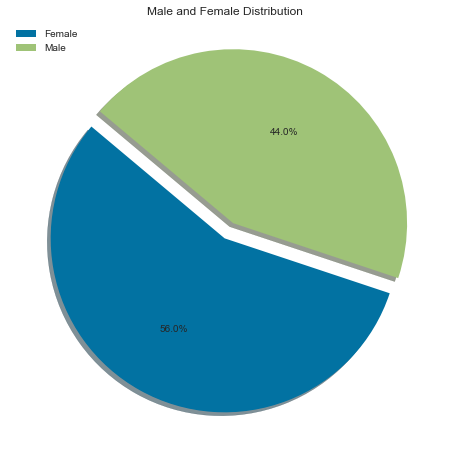

In [114]:
plt.figure(figsize=(8,8))

explode = [0,0.1]
plt.pie(df['gender'].value_counts(), explode=explode,autopct='%1.1f%%', shadow=True,startangle=140)
plt.legend(labels=['Female','Male'])
plt.title('Male and Female Distribution')
plt.axis('off')

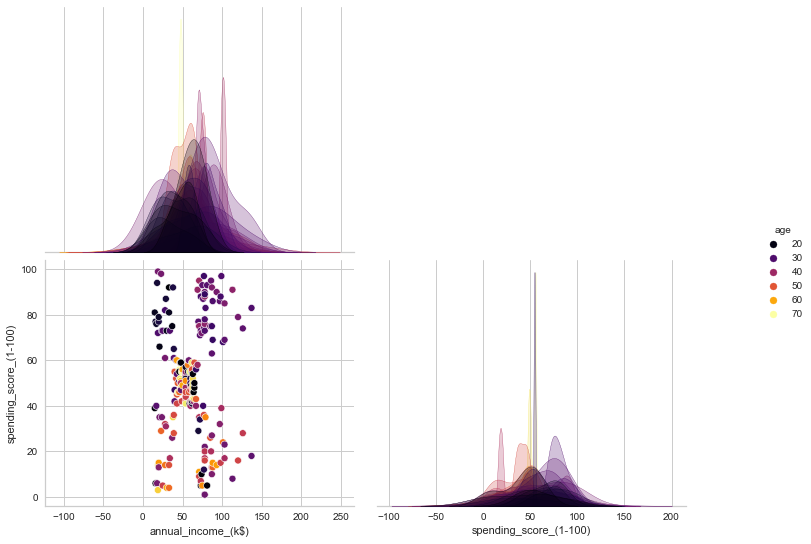

In [115]:
sns.pairplot(df, palette="inferno", hue="age", corner=True).fig.set_size_inches(12,8)

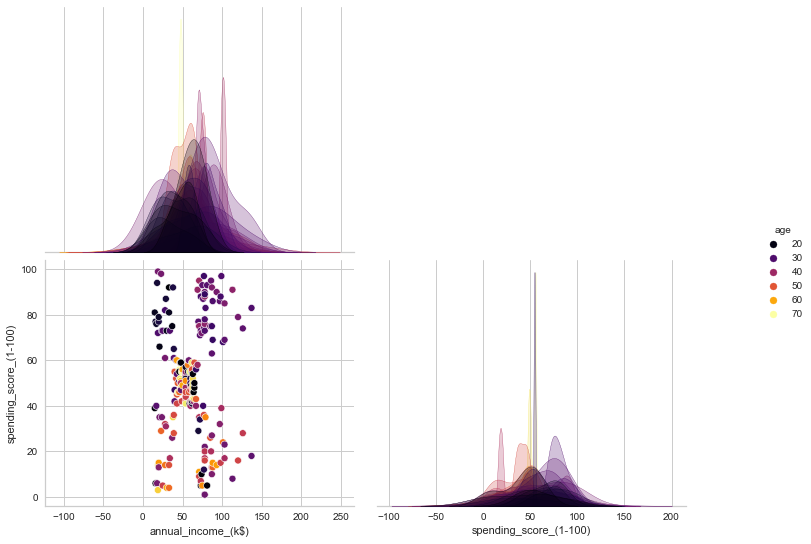

In [116]:
sns.pairplot(df, palette="inferno", hue="age", corner=True).fig.set_size_inches(12,8);

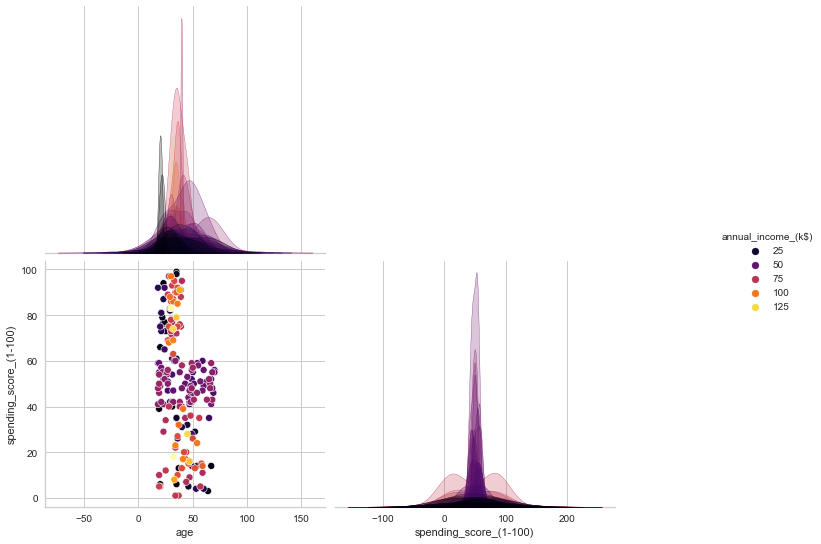

In [117]:
sns.pairplot(df, palette="inferno", hue="annual_income_(k$)", corner=True).fig.set_size_inches(12,8);

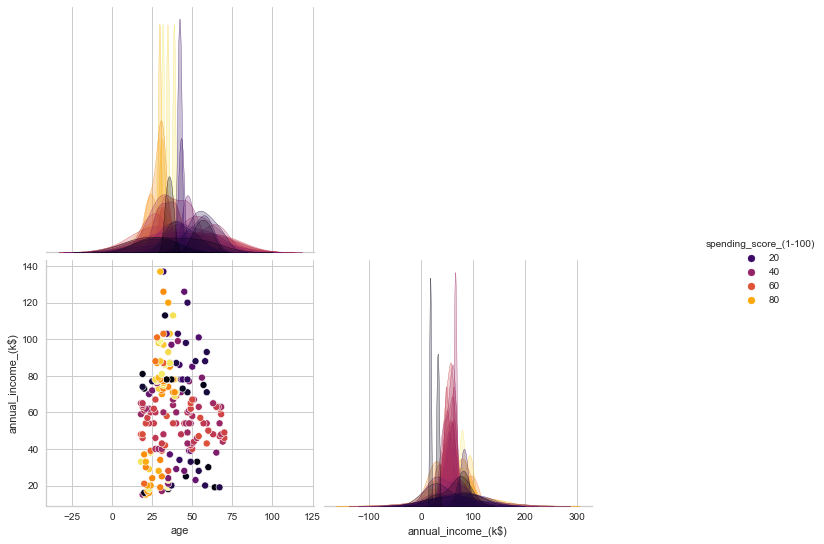

In [118]:
sns.pairplot(df, palette="inferno", hue="spending_score_(1-100)", corner=True).fig.set_size_inches(12,8);

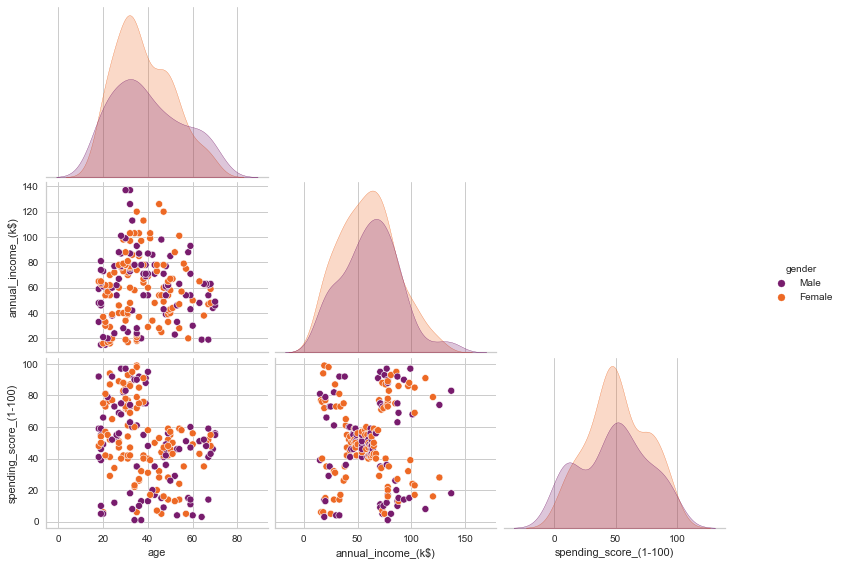

In [119]:
sns.pairplot(df, palette="inferno", hue="gender", corner=True).fig.set_size_inches(12,8);

<IPython.core.display.Javascript object>

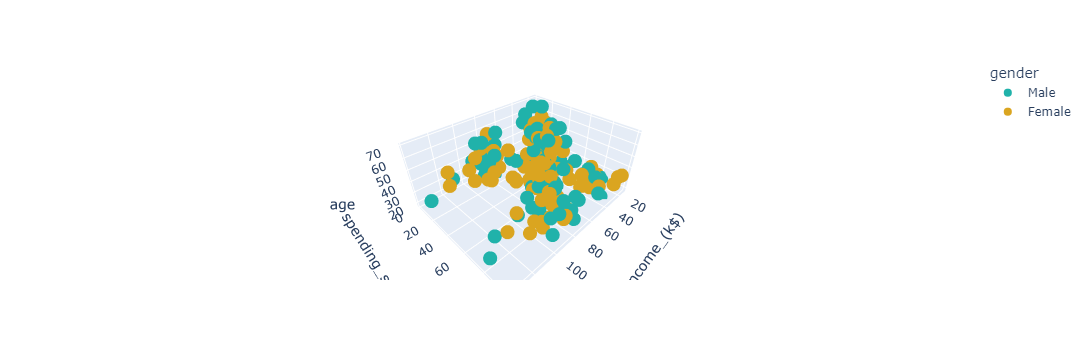

In [120]:
fig = px.scatter_3d(df, 
                    x="annual_income_(k$)",
                    y="spending_score_(1-100)",
                    z="age",
                    color='gender', 
                    color_discrete_sequence=["lightseagreen", "goldenrod"],
)
fig.show();

In [121]:
df.shape

(200, 4)

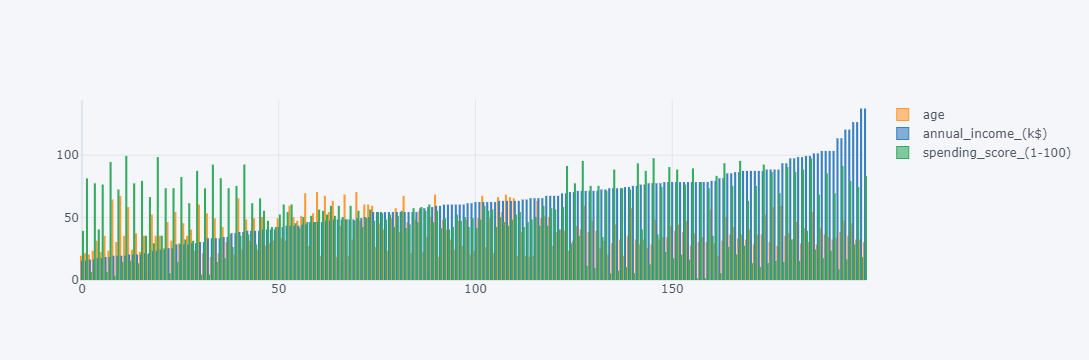

In [122]:
X_numerical.iplot(kind='bar');

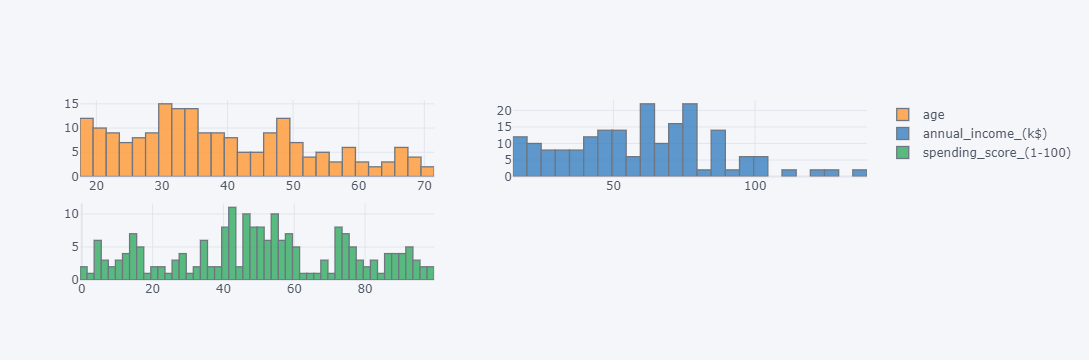

In [123]:
X_numerical.iplot(kind='histogram', subplots=True,bins=50);

Text(0, 0.5, 'Count')

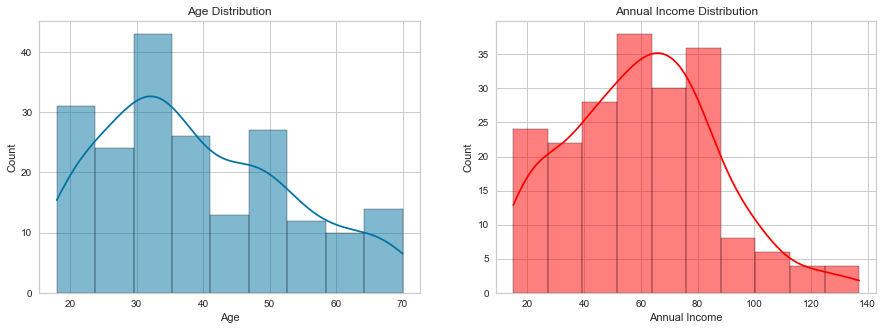

In [124]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(x='age', data=df, kde =True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

plt.subplot(1,2,2)
sns.histplot(x ='annual_income_(k$)', data=df, color='red', kde = True)
plt.title('Annual Income Distribution')
plt.xlabel('Annual Income')
plt.ylabel('Count')

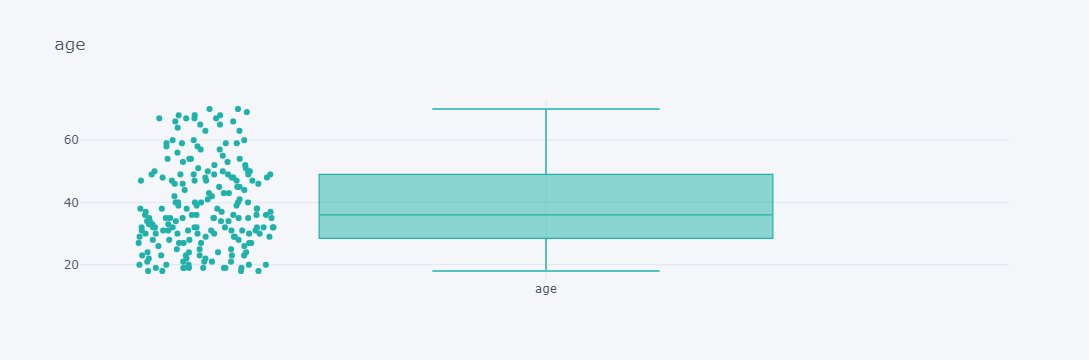

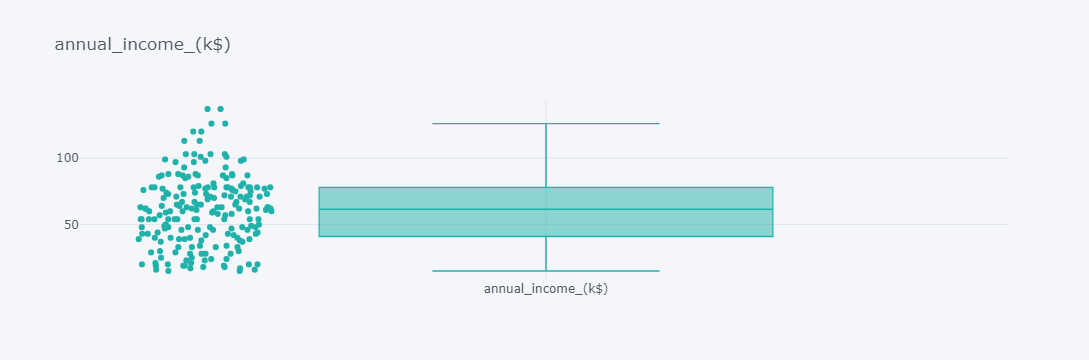

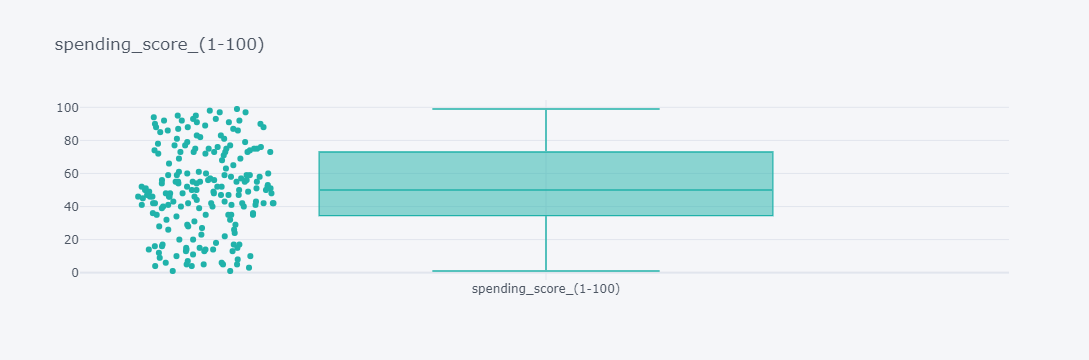

In [125]:
for i in df.drop(columns=[target]).columns:
    df[i].iplot(kind="box", title=i, boxpoints="all", color='lightseagreen')

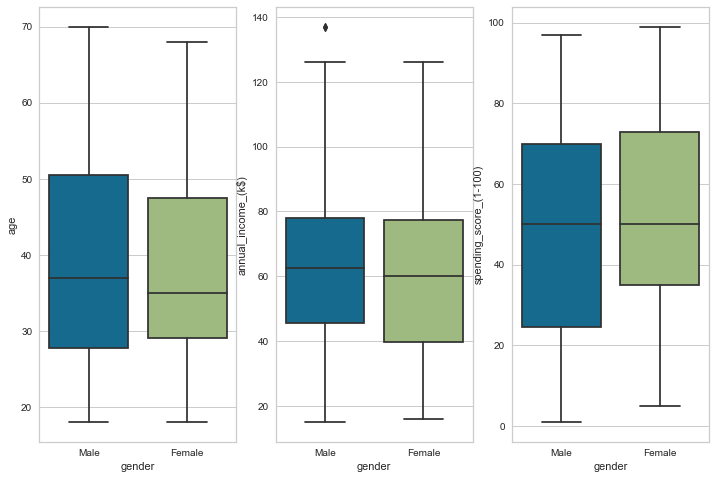

In [126]:
index = 0
plt.figure(figsize=(12, 8))
for feature in df.columns:
    if feature != target:
        index += 1
        plt.subplot(1, 3, index)
        sns.boxplot(x=target, y=feature, data=df)

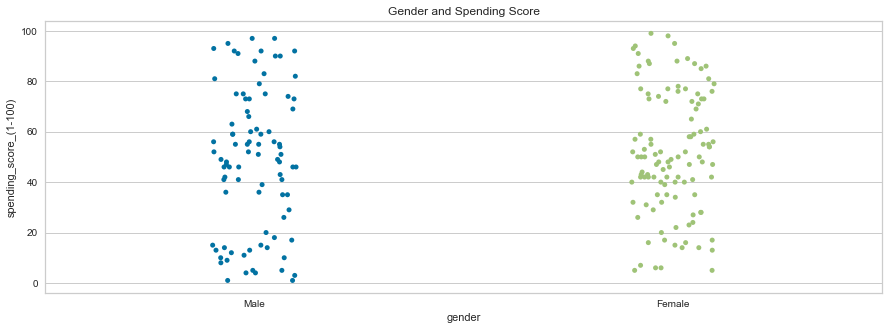

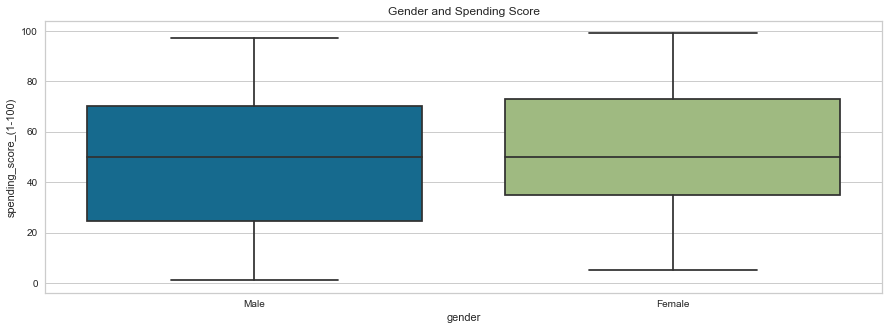

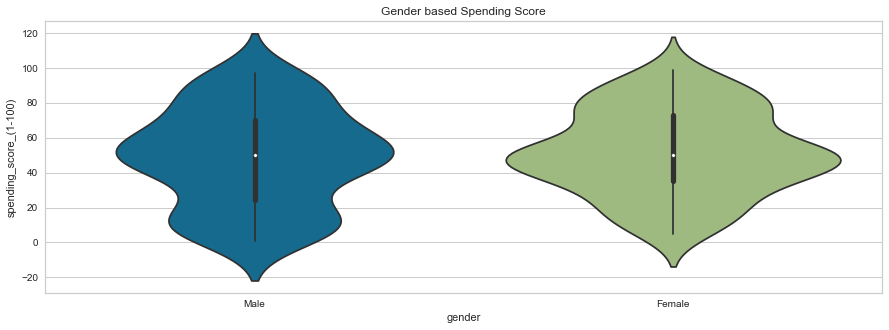

In [127]:
plt.figure(figsize=(15,5))
sns.stripplot(x='gender', y='spending_score_(1-100)', data=df)
plt.title('Gender and Spending Score')
plt.show()

plt.figure(figsize=(15,5))
sns.boxplot(x='gender', y='spending_score_(1-100)', data=df)
plt.title('Gender and Spending Score')
plt.show()

plt.figure(figsize=(15,5))
sns.violinplot(x='gender', y='spending_score_(1-100)', data=df)
plt.title('Gender based Spending Score')
plt.show()

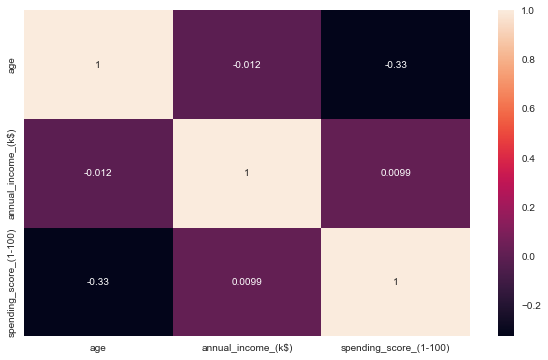

In [128]:
sns.heatmap(df.corr(), annot=True);

In [129]:
df.corr().style.background_gradient(cmap='RdPu')

,age,annual_income_(k$),spending_score_(1-100)
age,1.000000,-0.012398,-0.327227
annual_income_(k$),-0.012398,1.000000,0.009903
spending_score_(1-100),-0.327227,0.009903,1.000000


In [130]:
X_numerical.describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
age,200.000000,38.850000,13.969007,18.000000,28.750000,36.000000,49.000000,70.000000
annual_income_(k$),200.000000,60.560000,26.264721,15.000000,41.500000,61.500000,78.000000,137.000000
spending_score_(1-100),200.000000,50.200000,25.823522,1.000000,34.750000,50.000000,73.000000,99.000000


In [131]:
#Interpreting Skewness 
def skewness_control(df):
    skew_limit = 0.75 # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models. 
    skew_vals = X_numerical.skew().sort_values(ascending=False)
    print(skew_vals)
    skew_cols = skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
    print(skew_cols)

    for skew in skew_vals:
        if -0.5 < skew < 0.5:
            print ("A skewness value of", '\033[1m', Fore.GREEN, skew, 
                   '\033[0m', "means that the distribution is approx.", '\033[1m', Fore.GREEN, "symmetric", '\033[0m')
        elif  -0.5 < skew < -1.0 or 0.5 < skew < 1.0:
            print ("A skewness value of", '\033[1m', Fore.YELLOW, skew,
                   '\033[0m', "means that the distribution is approx.", '\033[1m', Fore.YELLOW, "moderately skewed", '\033[0m')
        else:
            print ("A skewness value of", '\033[1m', Fore.RED, skew, '\033[0m',
                   "means that the distribution is approx.", '\033[1m', Fore.RED, "highly skewed", '\033[0m')

In [132]:
skewness_control(df)

age                       0.486
annual_income_(k$)        0.322
spending_score_(1-100)   -0.047
dtype: float64
Series([], dtype: float64)
A skewness value of   0.48556885096681657  means that the distribution is approx.   symmetric 
A skewness value of   0.3218425498619055  means that the distribution is approx.   symmetric 
A skewness value of   -0.047220201374263374  means that the distribution is approx.   symmetric 


In [133]:
kurtosis_vals = df.kurtosis().sort_values(ascending=False)
kurtosis_vals

annual_income_(k$)       -0.098
age                      -0.672
spending_score_(1-100)   -0.827
dtype: float64

In [134]:
#Calculating Kurtosis 

kurtosis_limit = 7 
# This is our threshold-limit to evaluate skewness.
# Overall below abs(1) seems acceptable for the linear models.
kurtosis_vals = df.kurtosis()
kurtosis_cols = kurtosis_vals[abs(kurtosis_vals) > kurtosis_limit].sort_values(ascending=False)
kurtosis_cols

Series([], dtype: float64)

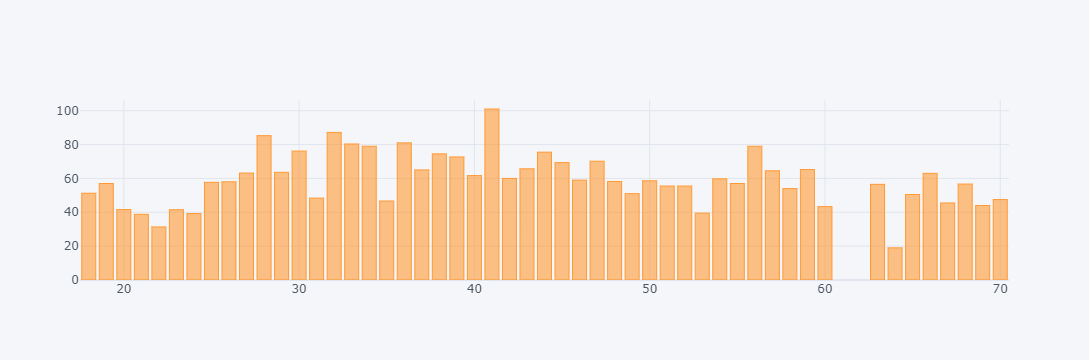

In [135]:
df.groupby("age")['annual_income_(k$)'].mean().sort_values(ascending=False).iplot(kind='bar');

In [136]:
df.groupby("age")['annual_income_(k$)'].mean().sort_values(ascending=False).nlargest(10)

age
41   101.000
32    87.182
28    85.250
36    81.000
33    80.333
56    79.000
34    79.000
30    76.143
44    75.500
38    74.500
Name: annual_income_(k$), dtype: float64

In [137]:
df.groupby("age")['annual_income_(k$)'].mean().sort_values(ascending=False).nsmallest(10)

age
64   19.000
22   31.333
21   38.800
24   39.250
53   39.500
23   41.500
20   41.600
60   43.333
69   44.000
67   45.500
Name: annual_income_(k$), dtype: float64

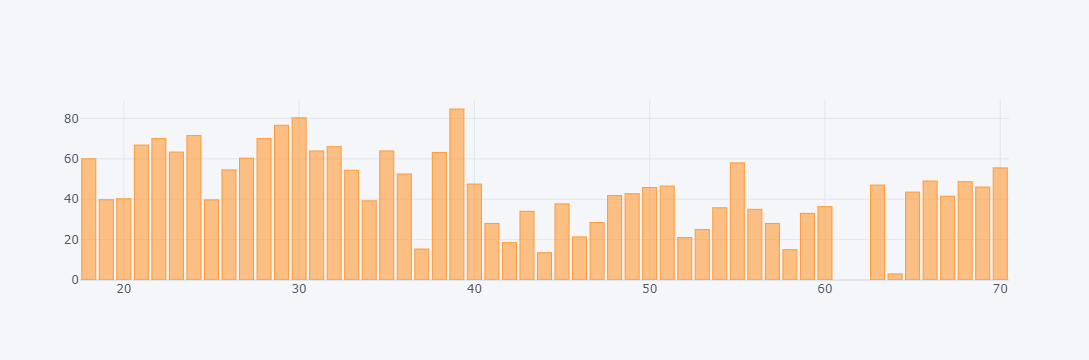

In [138]:
df.groupby("age")['spending_score_(1-100)'].mean().sort_values(ascending=False).iplot(kind="bar");

In [139]:
df.groupby("age")['spending_score_(1-100)'].mean().sort_values(ascending=False).nlargest(10)

age
39   84.667
30   80.286
29   76.600
24   71.500
22   70.000
28   70.000
21   66.800
32   66.000
35   63.889
31   63.875
Name: spending_score_(1-100), dtype: float64

In [140]:
df.groupby("age")['spending_score_(1-100)'].mean().sort_values(ascending=False).nsmallest(10)

age
64    3.000
44   13.500
58   15.000
37   15.333
42   18.500
52   21.000
46   21.333
53   25.000
57   28.000
41   28.000
Name: spending_score_(1-100), dtype: float64

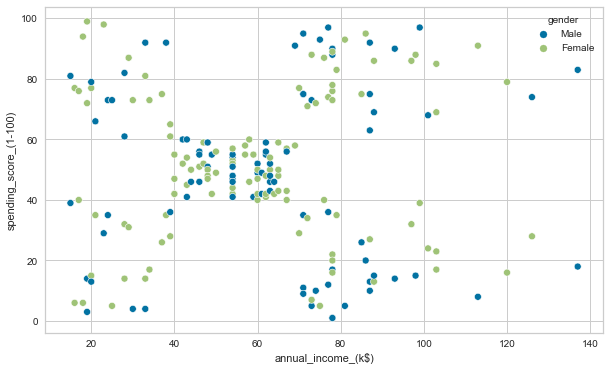

In [141]:
sns.scatterplot(data = df, x = "annual_income_(k$)", y = "spending_score_(1-100)", hue = "gender");

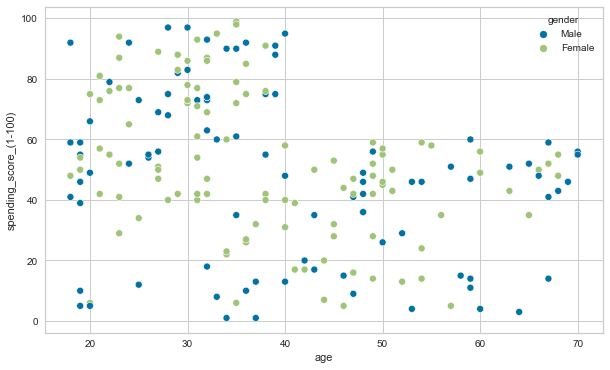

In [142]:
sns.scatterplot(data = df, x = "age", y = "spending_score_(1-100)", hue = "gender");

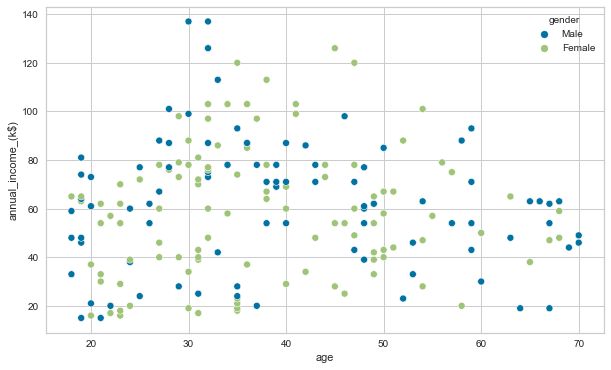

In [143]:
sns.scatterplot(data = df, x = "age", y = "annual_income_(k$)", hue = "gender");

Text(0.5, 1.0, 'Income')

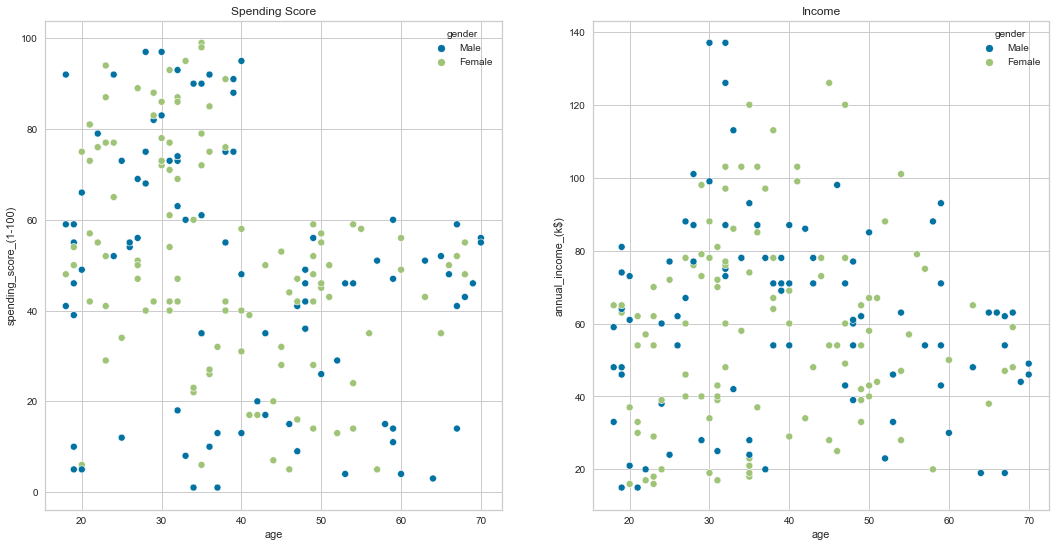

In [144]:
plt.figure(figsize=(18,9))
plt.subplot(121)
sns.scatterplot(data = df, x = "age",y = "spending_score_(1-100)", hue="gender")
plt.title("Spending Score")
plt.subplot(122)
sns.scatterplot(data = df, x = "age",y = "annual_income_(k$)", hue="gender")
plt.title("Income")

## 3. Cluster Analysis

The main purpose of this project is to perform [cluster analysis](https://en.wikipedia.org/wiki/Cluster_analysis#:~:text=Cluster%20analysis%20or%20clustering%20is,in%20other%20groups%20(clusters).) with the [K-Means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) algorithm. 

You can perform many [cluster analysis](http://www.stat.columbia.edu/~madigan/W2025/notes/clustering.pdf) using different variables. If you use a maximum of two variables for each cluster analysis, you can identify cluster labels more clearly.

First, the K-Means algorithm expects you to determine the number of clusters (*n_clusters*). You can determine the optimal number of clusters for each cluster analysis in various ways. In this case, you are expected to use the [Elbow Method](https://en.wikipedia.org/wiki/Elbow_method_(clustering).

Finally, different information is obtained in each analysis. Therefore, different labeling should be done as a result of each cluster analysis. 

Labeling example: 

- **Normal Customers**  -- An Average consumer in terms of spending and Annual Income
- **Spender Customers** --  Annual Income is less but spending high, so can also be treated as potential target customer.

### Clustering based on Age and Spending Score

#### *i. Create a new dataset with two variables of your choice*

In [145]:
df1 = df.drop(['gender', 'annual_income_(k$)'], axis=1)
df1.head()

,age,spending_score_(1-100)
0,19,39
1,21,81
2,20,6
3,23,77
4,31,40


In [146]:
from pyclustertend import hopkins
hopkins(df1, df1.shape[0])

0.2898383702226703

In [147]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
print("Scale:", hopkins(scale(df1), df1.shape[0]))
print("MinMax:", hopkins(MinMaxScaler().fit_transform(df1), df1.shape[0]))
print("StandardScale:", hopkins(StandardScaler().fit_transform(df1), df1.shape[0]))
#we don't need scale dataset

Scale: 0.28243233470696966
MinMax: 0.2888116868277176
StandardScale: 0.2940745597682022


#### *ii. Determine optimal number of clusters*

In [148]:
KMeans(random_state = 101).fit_predict(df1)

array([0, 3, 6, 3, 0, 3, 6, 2, 5, 3, 5, 2, 5, 3, 6, 3, 1, 3, 1, 2, 1, 3,
       5, 3, 5, 2, 1, 3, 1, 2, 5, 3, 5, 2, 5, 3, 5, 3, 1, 3, 7, 2, 1, 3,
       1, 3, 4, 0, 0, 0, 4, 3, 0, 7, 4, 4, 4, 7, 0, 4, 7, 0, 7, 4, 7, 0,
       4, 7, 0, 0, 7, 4, 7, 7, 7, 0, 4, 4, 0, 4, 7, 4, 7, 4, 0, 4, 4, 0,
       3, 4, 7, 0, 4, 1, 0, 0, 4, 0, 4, 0, 0, 4, 7, 0, 4, 0, 7, 4, 7, 7,
       7, 0, 1, 0, 0, 0, 7, 4, 4, 4, 0, 1, 4, 2, 1, 3, 1, 2, 5, 3, 5, 3,
       0, 3, 6, 2, 5, 3, 6, 3, 5, 2, 0, 2, 6, 2, 1, 3, 1, 2, 5, 2, 5, 3,
       5, 2, 6, 3, 6, 3, 1, 2, 6, 2, 1, 3, 1, 2, 1, 3, 5, 3, 6, 2, 5, 2,
       5, 3, 5, 2, 1, 2, 5, 2, 1, 2, 5, 3, 5, 2, 1, 3, 6, 2, 5, 3, 1, 3,
       6, 2])

##### Elbow Method , we use this method to find optimal k value by looking up to break point of graph. 

Text(0.5, 1.0, 'elbow method')

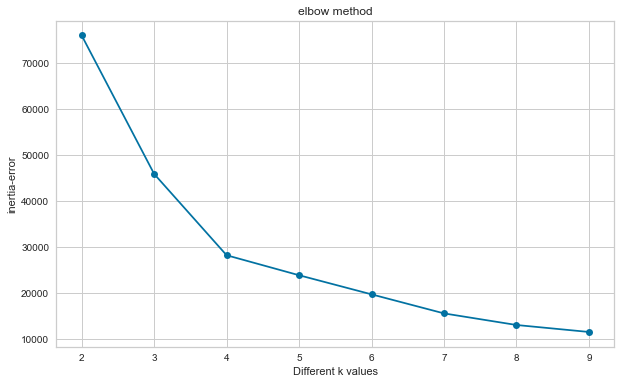

In [149]:
ssd = []
K = range(2,10)
for k in K:
    ssd.append(KMeans(n_clusters =k, random_state=101).fit(df1).inertia_)

plt.plot(K, ssd, "bo-")
plt.xlabel("Different k values")
plt.ylabel("inertia-error") 
plt.title("elbow method") 

In [150]:
ssd # sum of squared distance

[75949.15601023012,
 45840.67661610871,
 28165.583566629342,
 23818.848251581334,
 19664.73951714552,
 15523.684014328754,
 13002.4664883828,
 11486.150087792637]

In [151]:
df_diff =pd.DataFrame(-pd.Series(ssd).diff()).rename(index = lambda x : x+1)
df_diff

,0
1,NaN
2,30108.479
3,17675.093
4,4346.735
5,4154.109
6,4141.056
7,2521.218
8,1516.316


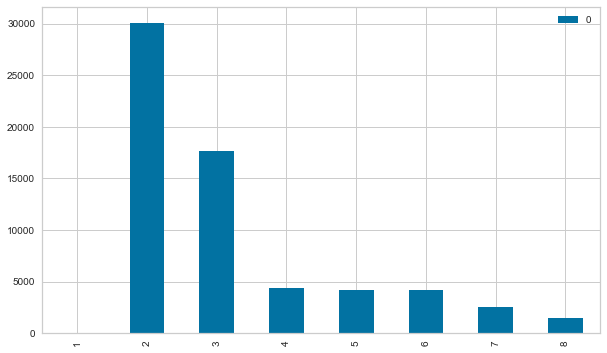

In [152]:
df_diff.plot(kind='bar');

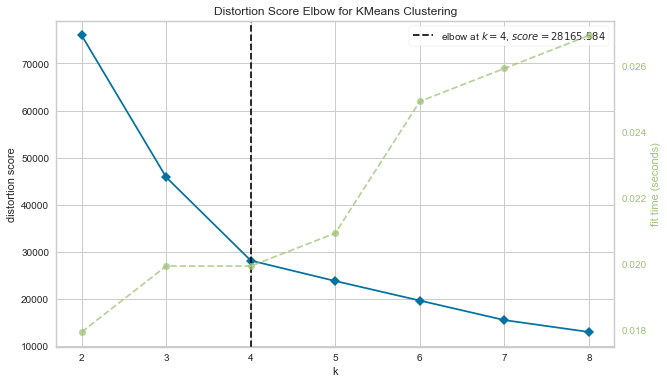

In [153]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(random_state=101), k=(2,9))
visualizer.fit(df1)        # Fit the data to the visualizer
visualizer.show();

In [154]:
from sklearn.metrics import silhouette_score
silhouette_score(df1, KMeans(random_state = 101).fit_predict(df1))

0.4331607448298594

In [155]:
range_n_clusters = range(2,9)
for num_clusters in range_n_clusters:
    silhouette_ = silhouette_score(df1, 
                                      KMeans(n_clusters=num_clusters, random_state=101).fit_predict(df1))
    print(f"For n_clusters={num_clusters}, the silhouette score is {silhouette_}")

For n_clusters=2, the silhouette score is 0.4692341232501655
For n_clusters=3, the silhouette score is 0.45300127016521263
For n_clusters=4, the silhouette score is 0.49973941540141753
For n_clusters=5, the silhouette score is 0.46342248553207704
For n_clusters=6, the silhouette score is 0.4235290823884998
For n_clusters=7, the silhouette score is 0.4212938931368575
For n_clusters=8, the silhouette score is 0.4331607448298594


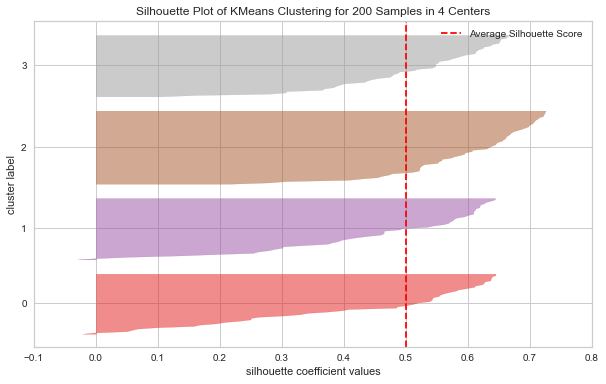

In [156]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

visualizer = SilhouetteVisualizer(KMeans(n_clusters=4, random_state=101))
visualizer.fit(df1)    # Fit the data to the visualizer
visualizer.poof();

#### *iii. Apply K Means*

In [157]:
KMeans(n_clusters = 4, random_state=101).fit_predict(df1)

array([0, 2, 1, 2, 0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 0, 0, 1, 2, 0, 2,
       1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 3, 2, 3, 0,
       1, 0, 3, 0, 0, 0, 3, 0, 0, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 0,
       3, 3, 0, 0, 3, 3, 3, 3, 3, 0, 3, 0, 0, 3, 3, 0, 3, 3, 0, 3, 3, 0,
       0, 3, 3, 0, 3, 0, 0, 0, 3, 0, 3, 0, 0, 3, 3, 0, 3, 0, 3, 3, 3, 3,
       3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 2, 0, 2, 3, 2, 1, 2, 1, 2,
       0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 1, 2, 3, 2, 1, 2, 1, 2, 1, 2,
       1, 2, 1, 2, 1, 2, 3, 2, 1, 2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 1, 2,
       1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
       1, 2])

#### *iv. Visualizing and Labeling All the Clusters*

In [158]:
df1["predicted_clusters_ageS"] = KMeans(n_clusters = 4, random_state=101).fit_predict(df1)
df1.head()

,age,spending_score_(1-100),predicted_clusters_ageS
0,19,39,0
1,21,81,2
2,20,6,1
3,23,77,2
4,31,40,0


Text(0.5, 1.0, 'No Cluster')

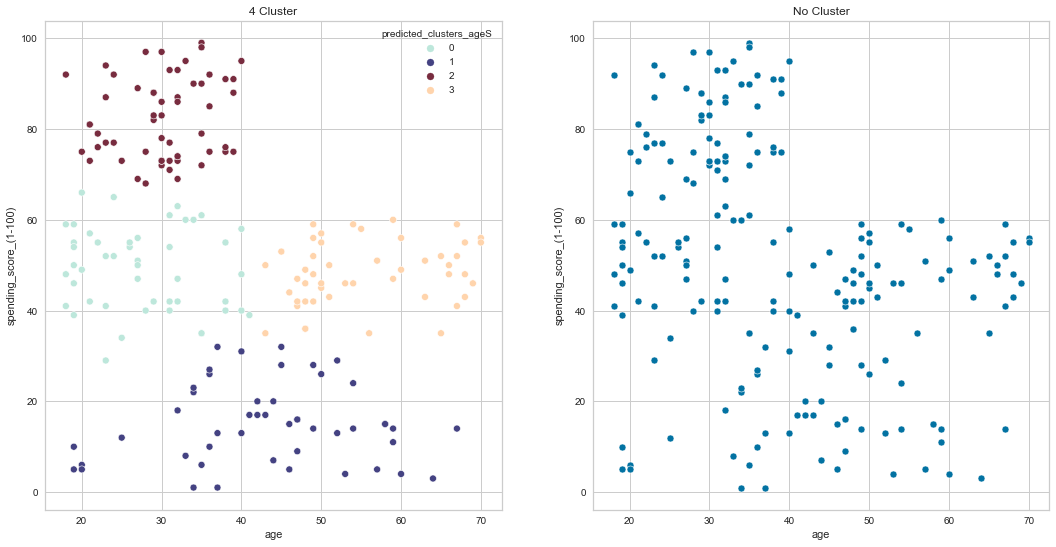

In [159]:
plt.figure(figsize=(18,9))
plt.subplot(1, 2, 1)
sns.scatterplot(data = df1, x = "age",y = "spending_score_(1-100)", palette="icefire", hue = 'predicted_clusters_ageS')
plt.title("4 Cluster")
plt.subplot(1, 2, 2)
sns.scatterplot(data = df1, x = "age",y = "spending_score_(1-100)")
plt.title("No Cluster")

### Clustering based on Annual Income and Spending Score

#### *i. Create a new dataset with two variables of your choice*

In [160]:
df2 = df.drop(['gender', 'age'], axis=1)
df2.head()

,annual_income_(k$),spending_score_(1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


In [161]:
hopkins(df2, df2.shape[0])

0.30760946872114664

#### *ii. Determine optimal number of clusters*

In [162]:
KMeans(random_state = 101).fit_predict(df2)

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 7, 3, 7, 7,
       4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 7, 1, 7, 1, 7, 7, 1, 1, 7, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 0, 5, 1, 5, 0, 5, 0, 5,
       1, 5, 0, 5, 0, 5, 0, 5, 0, 5, 1, 5, 0, 5, 1, 5, 0, 5, 0, 5, 0, 5,
       0, 5, 0, 5, 0, 5, 1, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5,
       0, 5, 0, 5, 6, 2, 6, 2, 6, 2, 6, 2, 6, 2, 6, 2, 6, 2, 6, 2, 6, 2,
       6, 2])

##### Elbow Method , we use this method to find optimal k value by looking up to break point of graph. 

Text(0.5, 1.0, 'elbow method')

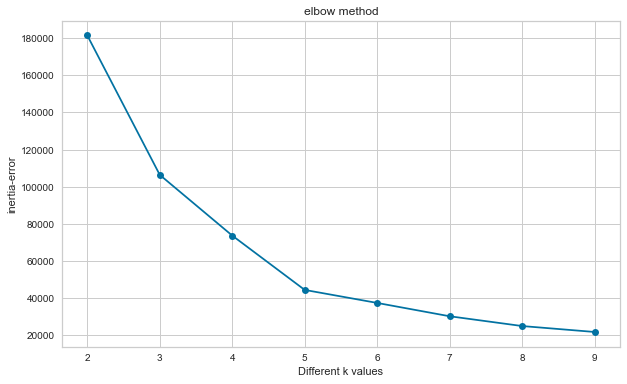

In [163]:
ssd = []
K = range(2,10)
for k in K:
    ssd.append(KMeans(n_clusters =k, random_state=101).fit(df2).inertia_)

plt.plot(K, ssd, "bo-")
plt.xlabel("Different k values")
plt.ylabel("inertia-error") 
plt.title("elbow method") 

In [164]:
ssd # sum of squared distance

[181363.59595959607,
 106348.37306211119,
 73679.78903948837,
 44448.45544793369,
 37442.24745037571,
 30273.394312070028,
 25011.920255473764,
 21818.11458845217]

In [165]:
df_diff =pd.DataFrame(-pd.Series(ssd).diff()).rename(index = lambda x : x+1)
df_diff

,0
1,NaN
2,75015.223
3,32668.584
4,29231.334
5,7006.208
6,7168.853
7,5261.474
8,3193.806


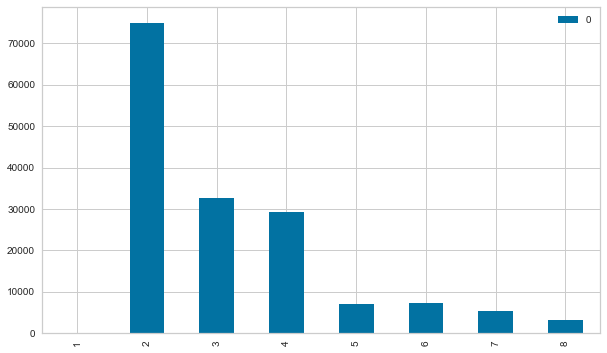

In [166]:
df_diff.plot(kind='bar');

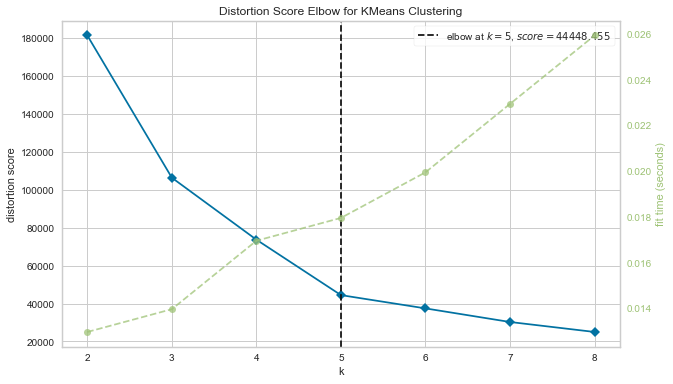

In [167]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(random_state=101), k=(2,9))
visualizer.fit(df2)        # Fit the data to the visualizer
visualizer.show();

In [168]:
from sklearn.metrics import silhouette_score
silhouette_score(df2, KMeans(random_state = 101).fit_predict(df2))

0.4551839202075395

In [169]:
range_n_clusters = range(2,9)
for num_clusters in range_n_clusters:
    silhouette_ = silhouette_score(df2, 
                                      KMeans(n_clusters=num_clusters, random_state=101).fit_predict(df2))
    print(f"For n_clusters={num_clusters}, the silhouette score is {silhouette_}")

For n_clusters=2, the silhouette score is 0.2968969162503008
For n_clusters=3, the silhouette score is 0.46761358158775435
For n_clusters=4, the silhouette score is 0.4931963109249047
For n_clusters=5, the silhouette score is 0.553931997444648
For n_clusters=6, the silhouette score is 0.5367558067779578
For n_clusters=7, the silhouette score is 0.5270287298101395
For n_clusters=8, the silhouette score is 0.4551839202075395


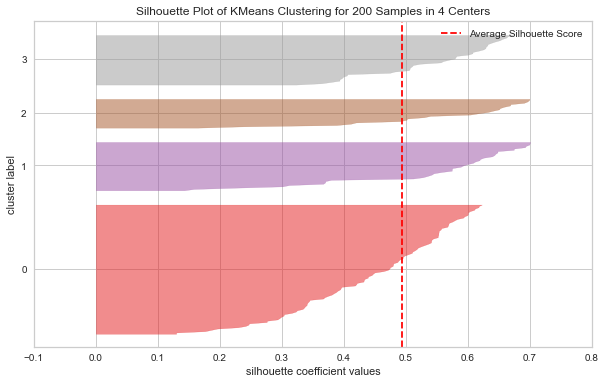

In [170]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

visualizer = SilhouetteVisualizer(KMeans(n_clusters=4, random_state=101))
visualizer.fit(df2)    # Fit the data to the visualizer
visualizer.poof();

#### *iii. Apply K Means*

In [171]:
KMeans(n_clusters = 5, random_state=101).fit_predict(df2)

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 0,
       4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 2, 1, 2, 1, 2,
       0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
       1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
       1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
       1, 2])

#### *iv. Visualizing and Labeling All the Clusters*

In [172]:
# with 5 clusters
df2["predicted_clusters_incomeS5"] = KMeans(n_clusters =5, random_state=101).fit_predict(df2)
df2.head()

,annual_income_(k$),spending_score_(1-100),predicted_clusters_incomeS5
0,15,39,4
1,15,81,3
2,16,6,4
3,16,77,3
4,17,40,4


In [173]:
# with 4 clusters
df2["predicted_clusters_incomeS4"] = KMeans(n_clusters =4, random_state=101).fit_predict(df2)
df2.head()

,annual_income_(k$),spending_score_(1-100),predicted_clusters_incomeS5,predicted_clusters_incomeS4
0,15,39,4,2
1,15,81,3,0
2,16,6,4,2
3,16,77,3,0
4,17,40,4,2


Text(0.5, 1.0, 'No Cluster')

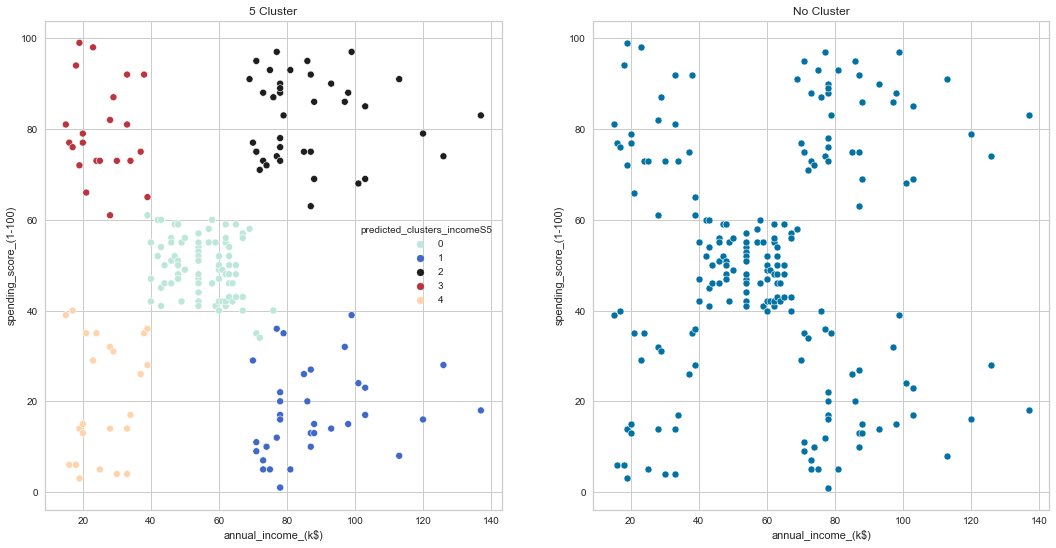

In [174]:
# with 5 clusters
plt.figure(figsize=(18,9))
plt.subplot(121)
sns.scatterplot(data = df2, x = "annual_income_(k$)", y = "spending_score_(1-100)", palette="icefire", hue = 'predicted_clusters_incomeS5')
plt.title("5 Cluster")
plt.subplot(122)
sns.scatterplot(data = df2, x = "annual_income_(k$)", y = "spending_score_(1-100)")
plt.title("No Cluster")

Text(0.5, 1.0, 'No Cluster')

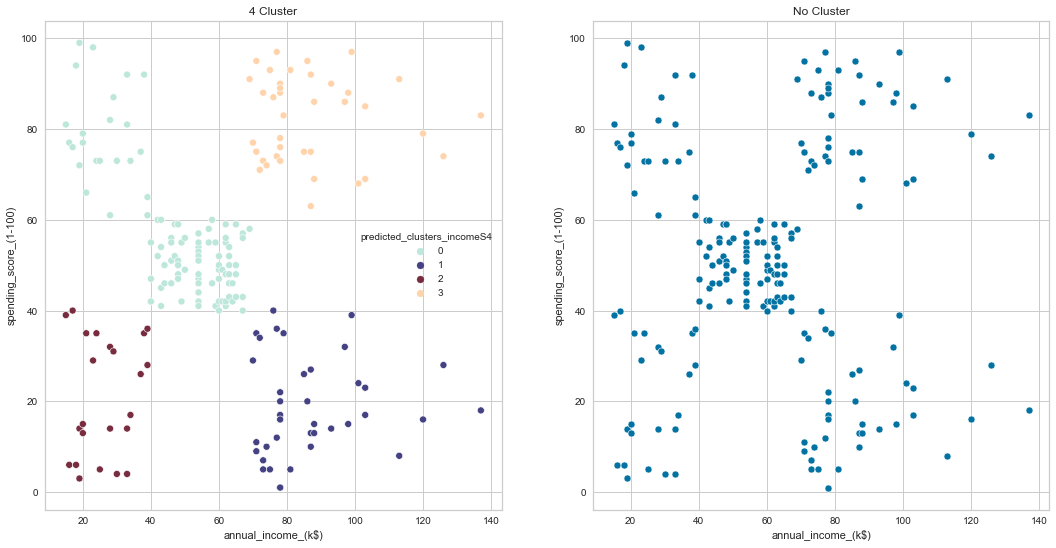

In [175]:
# with 4 clusters
plt.figure(figsize=(18,9))
plt.subplot(121)
sns.scatterplot(data = df2, x = "annual_income_(k$)", y = "spending_score_(1-100)", palette="icefire", hue = 'predicted_clusters_incomeS4')
plt.title("4 Cluster")
plt.subplot(122)
sns.scatterplot(data = df2, x = "annual_income_(k$)", y = "spending_score_(1-100)")
plt.title("No Cluster")

### Clustering based on Annual Income and Age

#### *i. Create a new dataset with two variables of your choice*

In [176]:
df3 = df.drop(['gender', 'spending_score_(1-100)'], axis=1)
df3.head()

,age,annual_income_(k$)
0,19,15
1,21,15
2,20,16
3,23,16
4,31,17


In [177]:
hopkins(df3, df3.shape[0])

0.329315639628807

#### *ii. Determine optimal number of clusters*

In [178]:
KMeans(random_state = 101).fit_predict(df3)

array([0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 7, 0, 7, 0, 0, 0, 0, 0, 7, 0, 0, 0,
       7, 0, 7, 0, 7, 0, 7, 0, 7, 0, 7, 6, 7, 6, 7, 6, 6, 6, 7, 6, 7, 6,
       7, 6, 7, 6, 6, 6, 7, 6, 6, 7, 7, 7, 7, 4, 6, 7, 4, 6, 4, 7, 4, 6,
       7, 4, 6, 6, 4, 7, 4, 4, 4, 6, 1, 1, 6, 1, 4, 1, 4, 1, 6, 1, 4, 3,
       1, 1, 4, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 1, 4, 3, 1, 3, 4, 1, 4, 4,
       4, 3, 1, 3, 3, 3, 4, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1,
       3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3,
       1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5,
       5, 5])

##### Elbow Method , we use this method to find optimal k value by looking up to break point of graph. 

Text(0.5, 1.0, 'elbow method')

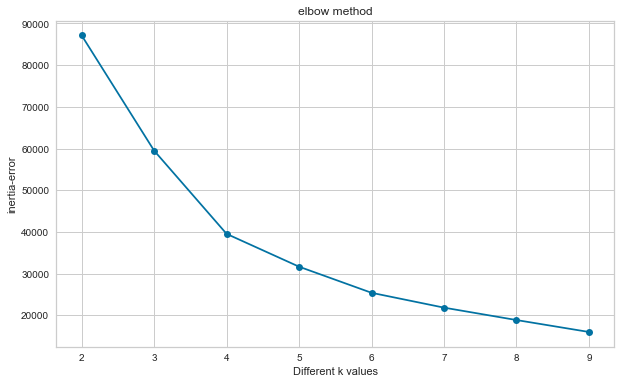

In [179]:
ssd = []
K = range(2,10)
for k in K:
    ssd.append(KMeans(n_clusters =k, random_state=101).fit(df3).inertia_)

plt.plot(K, ssd, "bo-")
plt.xlabel("Different k values")
plt.ylabel("inertia-error") 
plt.title("elbow method") 

In [180]:
ssd # sum of squared distance

[87121.56591478694,
 59486.961439280356,
 39529.887967363524,
 31659.353138717805,
 25399.022004416987,
 21839.63551628551,
 18864.876029385057,
 16004.320940988831]

In [181]:
df_diff =pd.DataFrame(-pd.Series(ssd).diff()).rename(index = lambda x : x+1)
df_diff

,0
1,NaN
2,27634.604
3,19957.073
4,7870.535
5,6260.331
6,3559.386
7,2974.759
8,2860.555


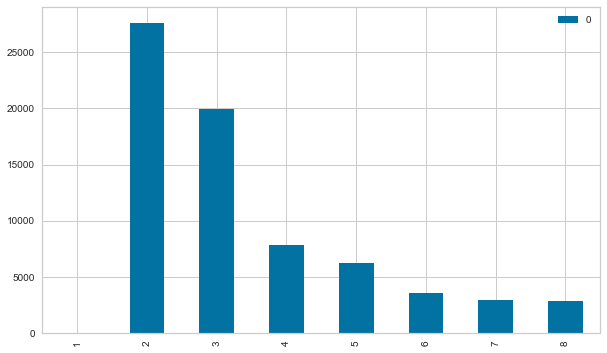

In [182]:
df_diff.plot(kind='bar');

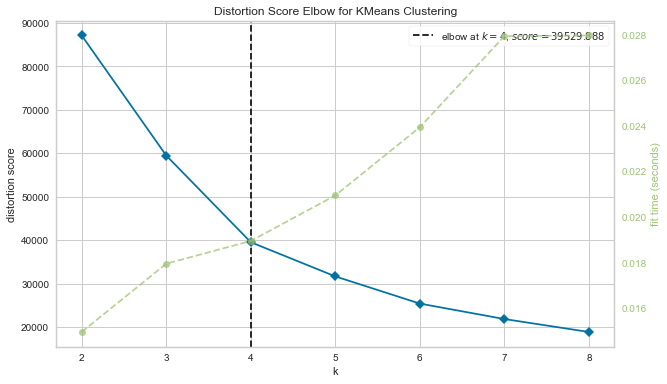

In [183]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(random_state=101), k=(2,9))
visualizer.fit(df3)        # Fit the data to the visualizer
visualizer.show();

In [184]:
from sklearn.metrics import silhouette_score
silhouette_score(df3, KMeans(random_state = 101).fit_predict(df3))

0.394180001823819

In [191]:
# range_n_clusters = range(2,200)
# for num_clusters in range_n_clusters:
#     silhouette_ = silhouette_score(df3, 
#                                       KMeans(n_clusters=num_clusters, random_state=101).fit_predict(df3))
#     print(f"For n_clusters={num_clusters}, the silhouette score is {silhouette_}")

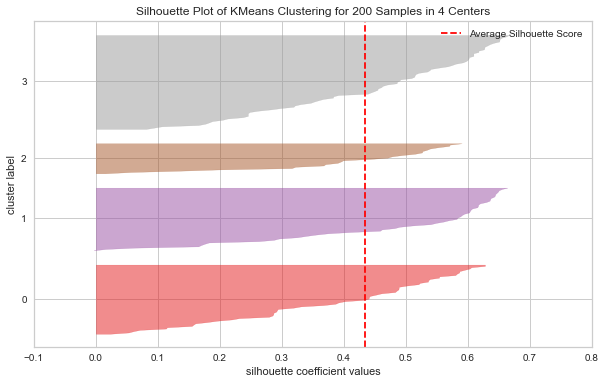

In [192]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

visualizer = SilhouetteVisualizer(KMeans(n_clusters=4, random_state=101))
visualizer.fit(df3)    # Fit the data to the visualizer
visualizer.poof();

#### *iii. Apply K Means*

In [193]:
KMeans(n_clusters =4, random_state=101).fit_predict(df3)

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 3,
       3, 0, 0, 3, 0, 3, 3, 3, 0, 3, 0, 3, 3, 0, 0, 3, 0, 3, 0, 0, 0, 0,
       0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3,
       2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

#### *iv. Visualizing and Labeling All the Clusters*

In [194]:
df3["predicted_clusters_incomeAge"] = KMeans(n_clusters =4, random_state=101).fit_predict(df3)
df3

,age,annual_income_(k$),predicted_clusters_incomeAge
0,19,15,1
1,21,15,1
2,20,16,1
3,23,16,1
4,31,17,1
5,22,17,1
6,35,18,1
7,23,18,1
8,64,19,0
9,30,19,1


Text(0.5, 1.0, 'No Cluster')

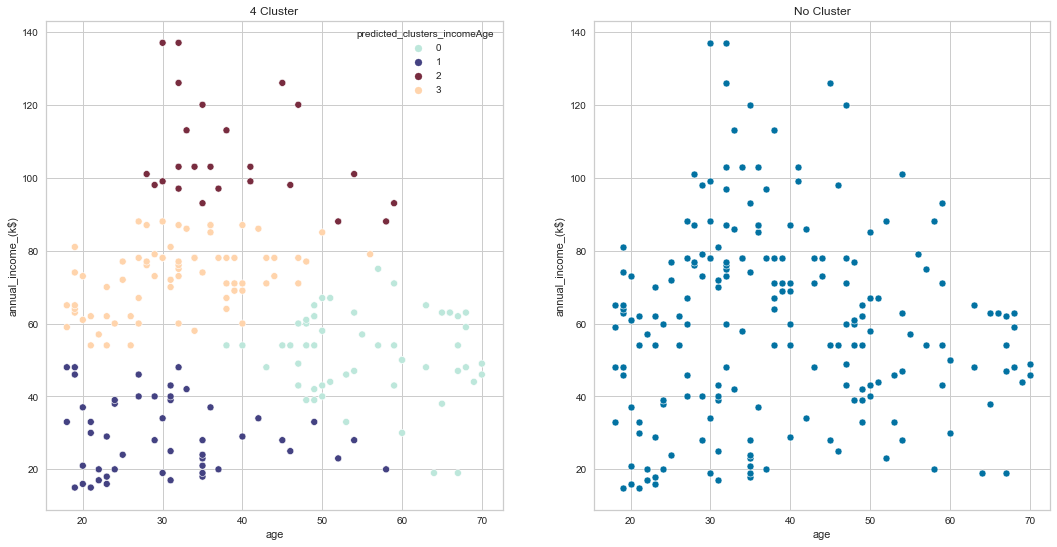

In [195]:
plt.figure(figsize=(18,9))
plt.subplot(121)
sns.scatterplot(data = df3, x = "age", y = "annual_income_(k$)", palette="icefire", hue = 'predicted_clusters_incomeAge')
plt.title("4 Cluster")
plt.subplot(122)
sns.scatterplot(data = df3, x = "age", y = "annual_income_(k$)")
plt.title("No Cluster")

##### Compare all three clusters

In [209]:
df = df.join([df1["predicted_clusters_ageS"],
              df2["predicted_clusters_incomeS4"], 
              df2["predicted_clusters_incomeS5"],
              df3["predicted_clusters_incomeAge"]])
df.head()

In [197]:
df["predicted_clusters_ageS"].value_counts()

2    57
1    48
3    48
0    47
Name: predicted_clusters_ageS, dtype: int64

In [198]:
df["predicted_clusters_incomeS4"].value_counts()

0    100
3     39
1     38
2     23
Name: predicted_clusters_incomeS4, dtype: int64

In [199]:
df["predicted_clusters_incomeS5"].value_counts()

0    81
2    39
1    35
4    23
3    22
Name: predicted_clusters_incomeS5, dtype: int64

In [200]:
df["predicted_clusters_incomeAge"].value_counts()

3    73
0    54
1    49
2    24
Name: predicted_clusters_incomeAge, dtype: int64

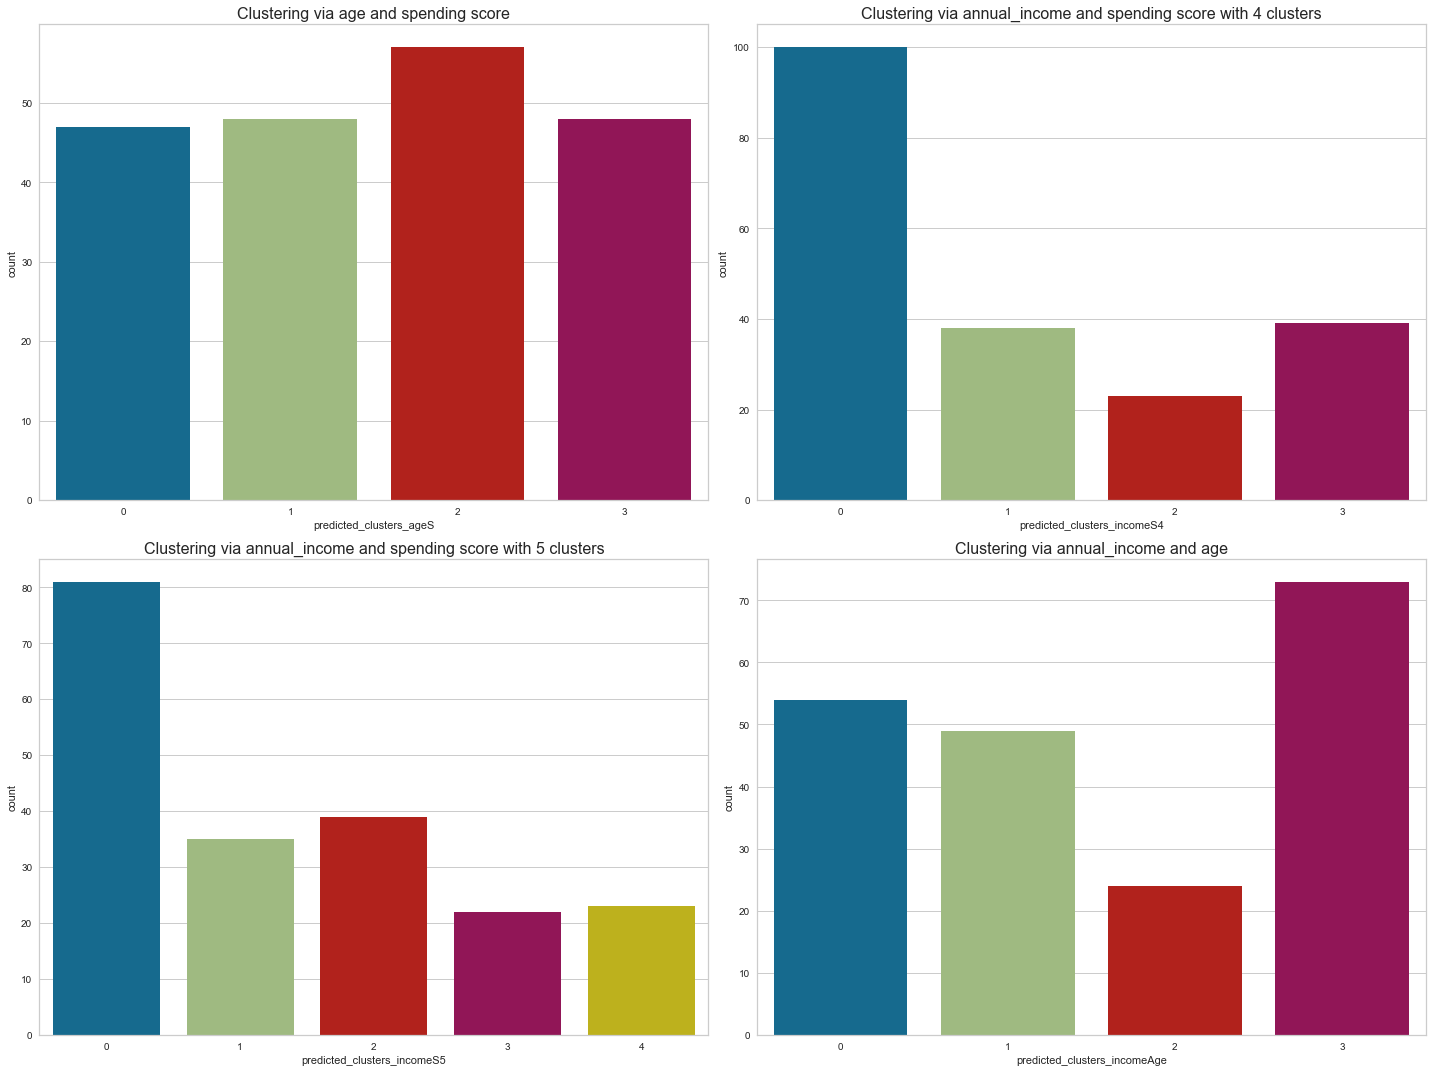

In [201]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 15))

sns.countplot(x=df["predicted_clusters_ageS"], data=df, ax=ax[0,0])     
sns.countplot(x=df["predicted_clusters_incomeS4"], data=df, ax=ax[0,1])
sns.countplot(x=df["predicted_clusters_incomeS5"], data=df, ax=ax[1,0])
sns.countplot(x=df["predicted_clusters_incomeAge"], data=df, ax=ax[1,1])
        
ax[0][0].set_title("Clustering via age and spending score", fontsize = 16)
ax[0][1].set_title("Clustering via annual_income and spending score with 4 clusters", fontsize = 16)
ax[1][0].set_title("Clustering via annual_income and spending score with 5 clusters", fontsize = 16)
ax[1][1].set_title("Clustering via annual_income and age", fontsize = 16)
plt.tight_layout();

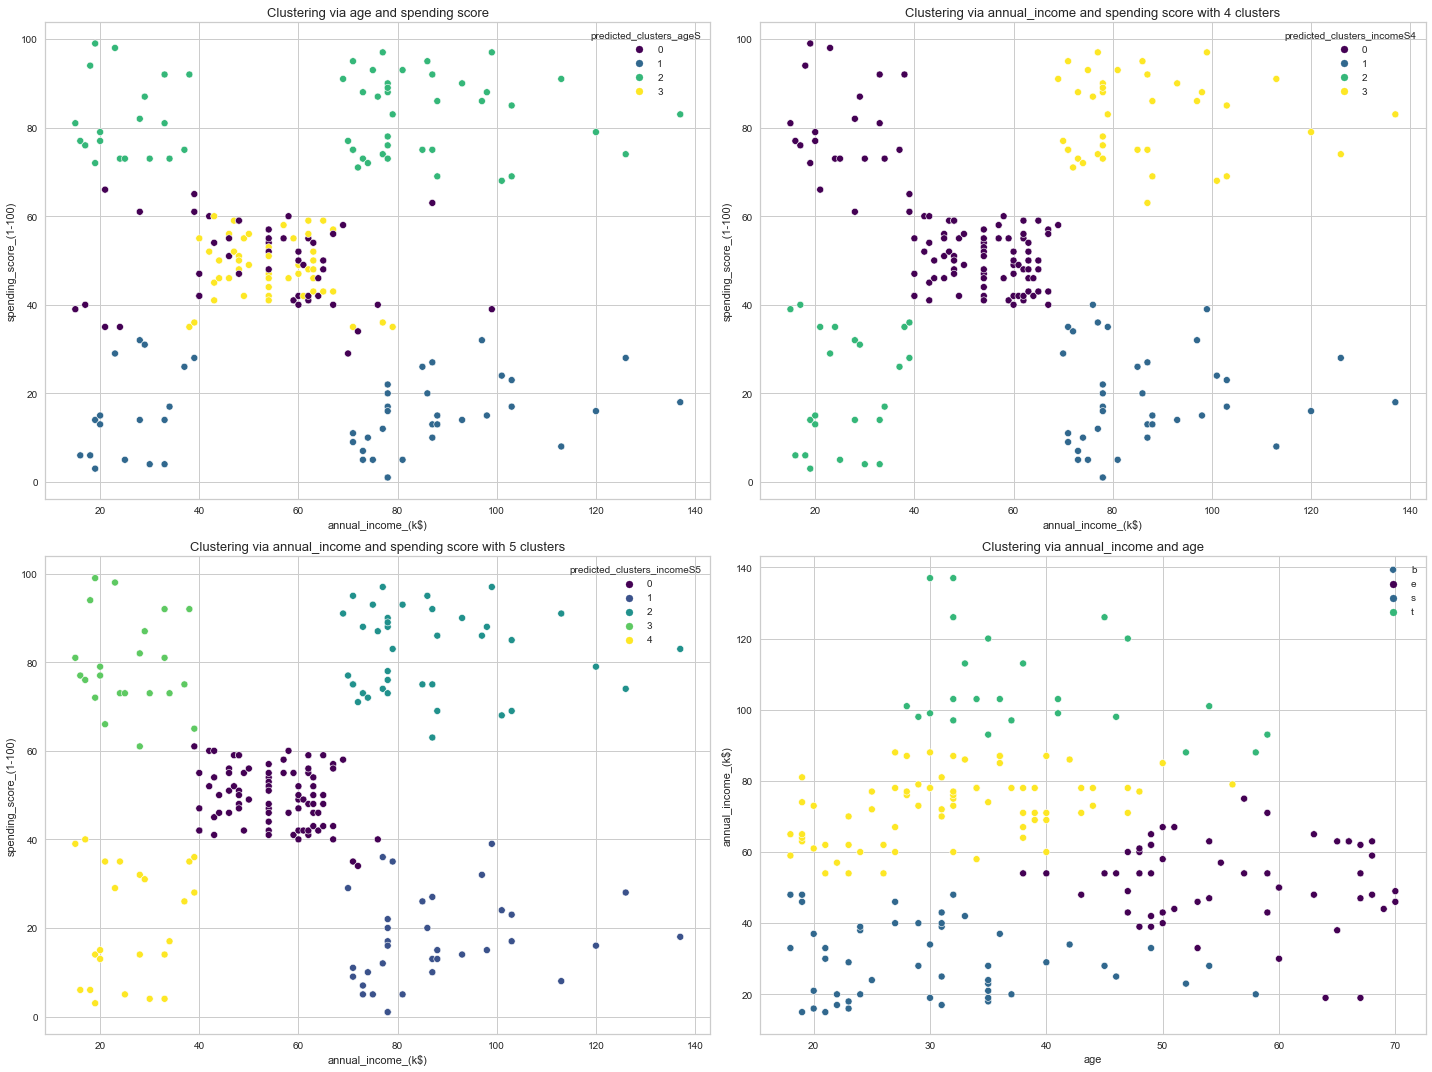

In [202]:
fig, ax =plt.subplots(nrows = 2, ncols = 2, figsize = (20, 15))


sns.scatterplot(df["annual_income_(k$)"], 
                df["spending_score_(1-100)"], hue= df["predicted_clusters_ageS"], palette= "viridis", ax=ax[0,0]);


sns.scatterplot(df["annual_income_(k$)"], 
                df["spending_score_(1-100)"], hue= df["predicted_clusters_incomeS4"], palette= "viridis", ax=ax[0,1]);


sns.scatterplot(df["annual_income_(k$)"], 
                df["spending_score_(1-100)"], hue= df["predicted_clusters_incomeS5"], palette= "viridis", ax=ax[1,0]);

sns.scatterplot(df["age"],
                df["annual_income_(k$)"], hue= df["predicted_clusters_incomeAge"], palette= "viridis", ax=ax[1,1]);

ax[0][0].set_title("Clustering via age and spending score", fontsize = 13)
ax[0][1].set_title("Clustering via annual_income and spending score with 4 clusters", fontsize = 13)
ax[1][0].set_title("Clustering via annual_income and spending score with 5 clusters", fontsize = 13)
ax[1][1].set_title("Clustering via annual_income and age", fontsize = 13);
plt.legend("best")
plt.tight_layout();

<IPython.core.display.Javascript object>

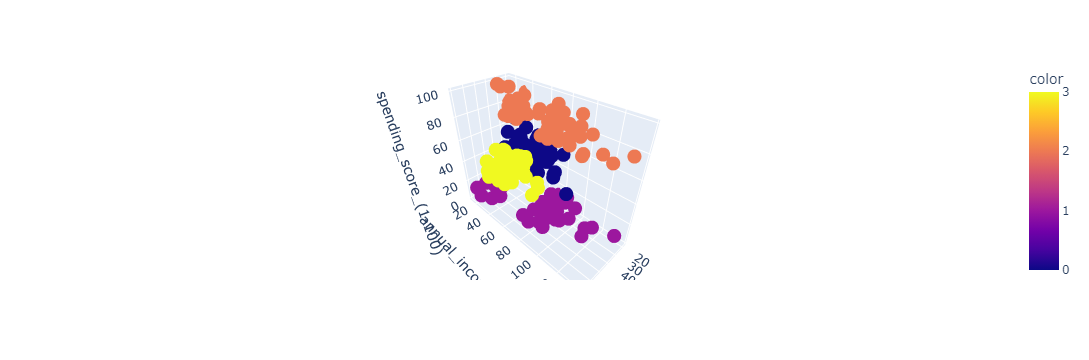

In [203]:
# clustering via age and spending_score
fig = px.scatter_3d(x=df["age"],
                    y=df["annual_income_(k$)"],
                    z=df["spending_score_(1-100)"],
                    color=df["predicted_clusters_ageS"],
                    labels = {"x": "age",
                              "y": "annual_income_(k$)",
                              "z": "spending_score_(1-100)"},
                    hover_name=df["gender"])
fig.show()

<IPython.core.display.Javascript object>

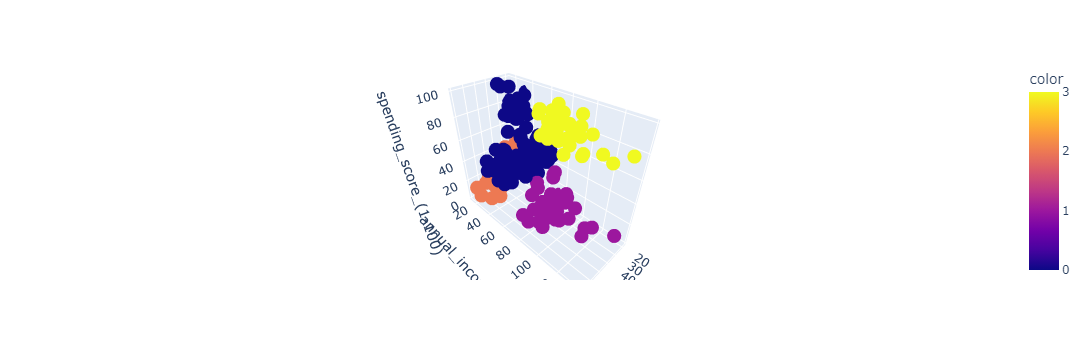

In [204]:
# clustering via annual_income and spending_score
fig = px.scatter_3d(x=df["age"],
                    y=df["annual_income_(k$)"],
                    z=df["spending_score_(1-100)"],
                    color=df["predicted_clusters_incomeS4"],
                    labels = {"x": "age",
                              "y": "annual_income_(k$)",
                              "z": "spending_score_(1-100)"},
                   hover_name=df["gender"])

fig.show()

<IPython.core.display.Javascript object>

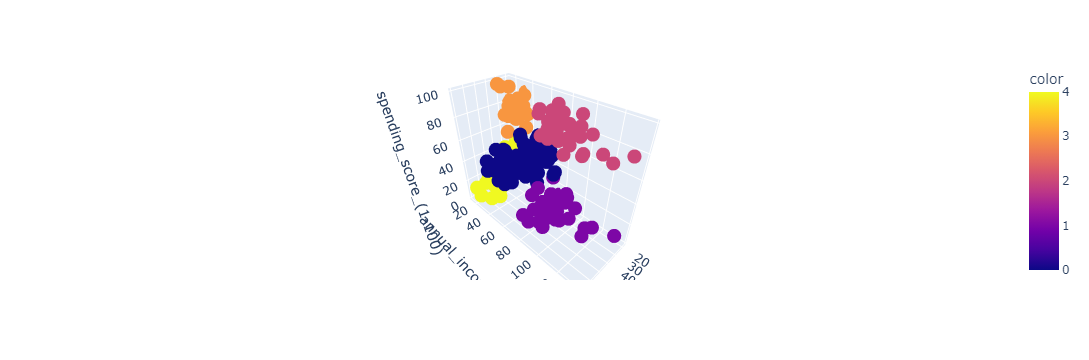

In [205]:
# clustering via annual_income and spending_score
fig = px.scatter_3d(x=df["age"],
                    y=df["annual_income_(k$)"],
                    z=df["spending_score_(1-100)"],
                    color=df["predicted_clusters_incomeS5"],
                    labels = {"x": "age",
                              "y": "annual_income_(k$)",
                              "z": "spending_score_(1-100)"},
                    hover_name=df["gender"])
fig.show()

<IPython.core.display.Javascript object>

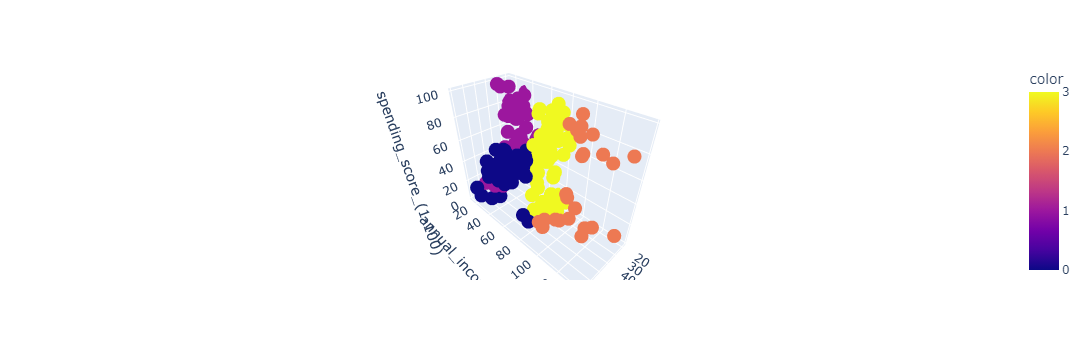

In [206]:
# clustering via annual_income and age
fig = px.scatter_3d(x=df["age"],
                    y=df["annual_income_(k$)"],
                    z=df["spending_score_(1-100)"],
                    color=df["predicted_clusters_incomeAge"],
                    labels = {"x": "age",
                              "y": "annual_income_(k$)",
                              "z": "spending_score_(1-100)"},
                    hover_name=df["gender"])
fig.show()

### Hierarchical Clustering

# df1

#### *i. Determine optimal number of clusters using Dendogram*

In [207]:
df1_ = df1.drop("predicted_clusters_ageS", axis=1).copy()
df1_.head()

,age,spending_score_(1-100)
0,19,39
1,21,81
2,20,6
3,23,77
4,31,40


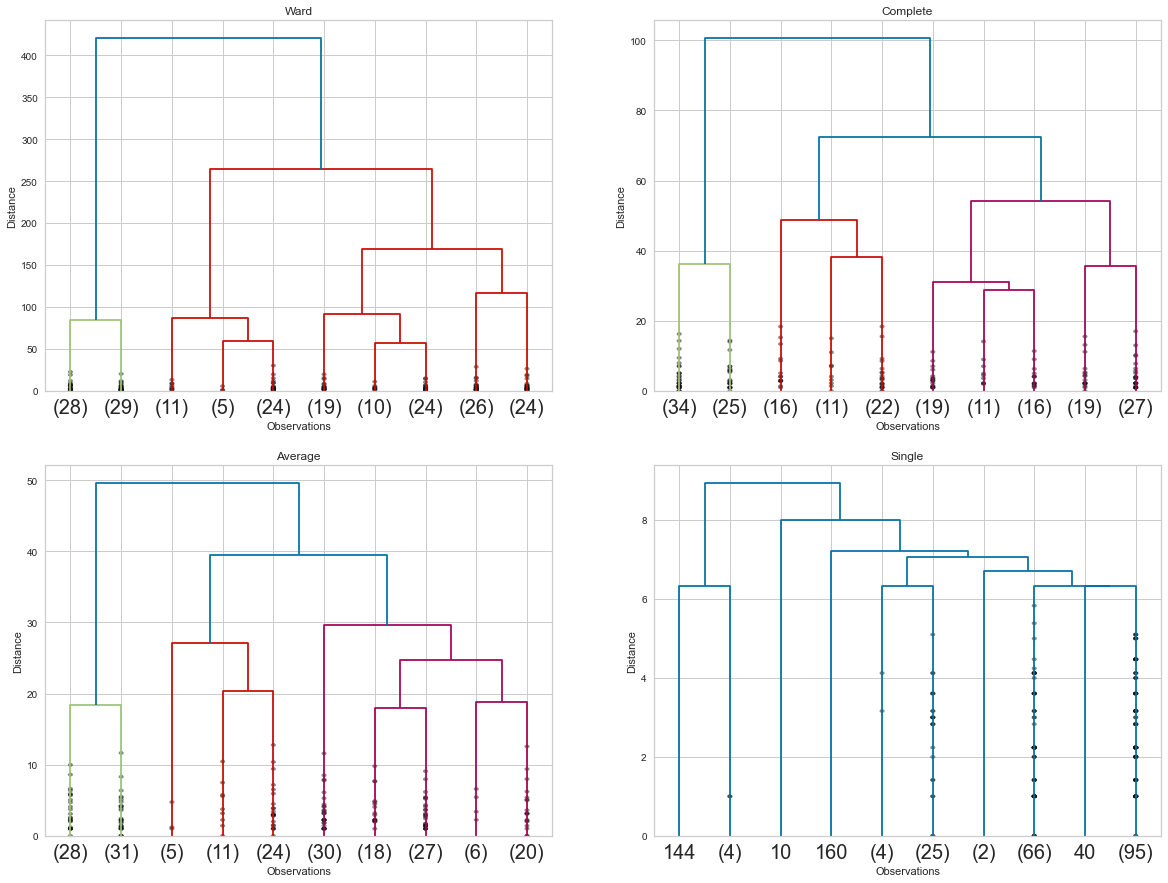

In [212]:
hc_ward = linkage(y = df1_, method = "ward")
hc_complete = linkage(df1_, "complete")
hc_average = linkage(df1_, "average")
hc_single = linkage(df1_, "single")

plt.figure(figsize = (20, 15))

plt.subplot(221)
plt.title("Ward")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_ward, truncate_mode = "lastp", p = 10, show_contracted = True, leaf_font_size = 20)

plt.subplot(222)
plt.title("Complete")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_complete, truncate_mode = "lastp", p = 10, show_contracted = True, leaf_font_size = 20)

plt.subplot(223)
plt.title("Average")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_average, truncate_mode = "lastp", p = 10, show_contracted = True, leaf_font_size = 20)

plt.subplot(224)
plt.title("Single")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_single, truncate_mode = "lastp", p = 10, show_contracted = True, leaf_font_size = 20);

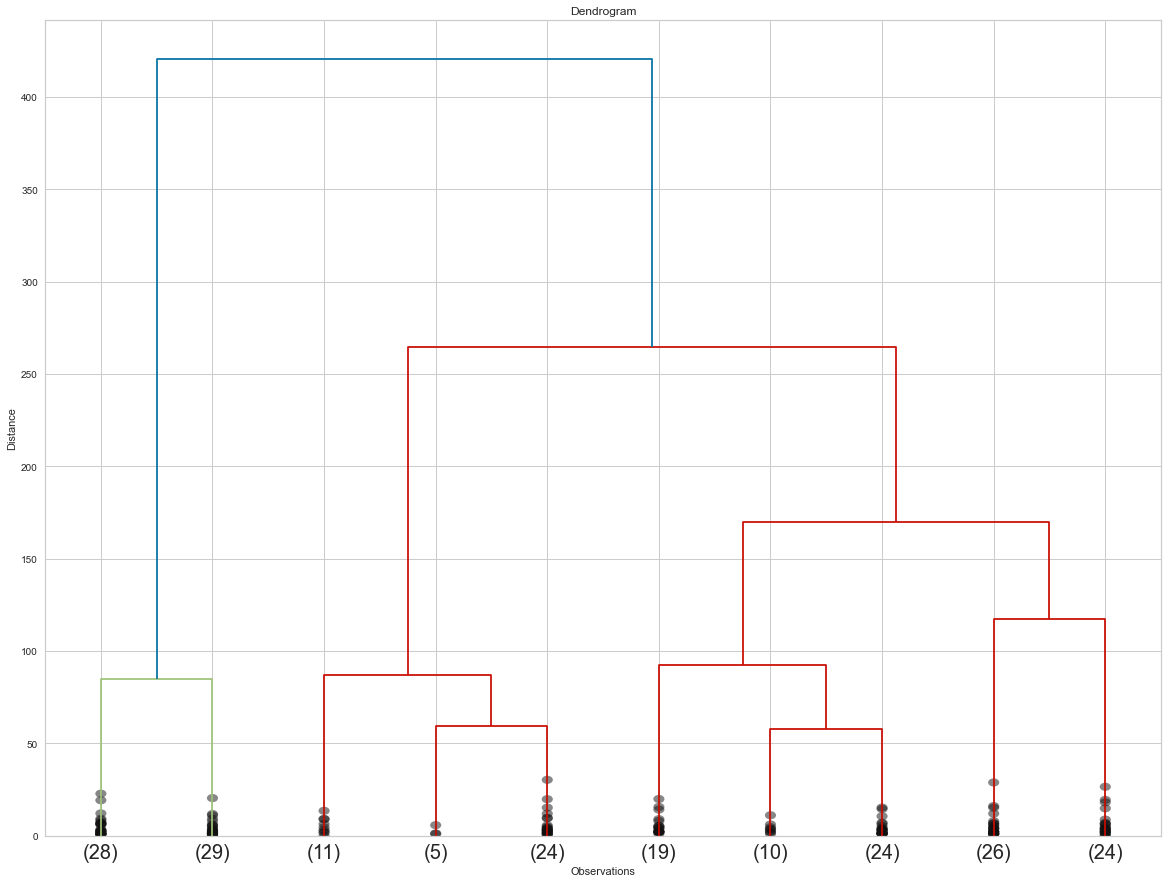

In [213]:
plt.figure(figsize = (20, 15))
plt.title("Dendrogram")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(linkage(df1_, method = "ward"), truncate_mode = "lastp", p = 10, show_contracted = True, leaf_font_size = 20);

In [214]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
K = range(2,10)

for k in K:
    model_labels = AgglomerativeClustering(n_clusters = k,  
                                           affinity='euclidean', 
                                           linkage='ward').fit_predict(df1_)
    print(f'Silhouette Score for {k} clusters: {silhouette_score(df1_, model_labels)}')

Silhouette Score for 2 clusters: 0.4549465643222241
Silhouette Score for 3 clusters: 0.4411791686353356
Silhouette Score for 4 clusters: 0.4602496389565028
Silhouette Score for 5 clusters: 0.40374071753059787
Silhouette Score for 6 clusters: 0.4125958704145705
Silhouette Score for 7 clusters: 0.4158977524079244
Silhouette Score for 8 clusters: 0.3883688959732531
Silhouette Score for 9 clusters: 0.3948151533262091


#### ii. *Apply Agglomerative Clustering*

In [215]:
model_labels = AgglomerativeClustering(n_clusters = 4,
                                       affinity='euclidean',
                                       linkage='ward').fit_predict(df1_)
model_labels

array([0, 3, 2, 3, 0, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 0, 0, 0, 3, 0, 3,
       2, 3, 2, 3, 0, 1, 0, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 1, 3, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 3, 0, 3, 0, 3, 2, 3, 2, 3,
       0, 3, 2, 3, 2, 3, 2, 3, 2, 3, 0, 3, 2, 3, 0, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 1, 3, 2, 3, 0, 3, 2, 3, 2, 1, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 0, 3, 2, 3, 0, 3, 0, 3, 2, 3, 2, 3, 2, 3, 2, 3, 0, 3,
       2, 3], dtype=int64)

In [217]:
df1_

,age,spending_score_(1-100)
0,19,39
1,21,81
2,20,6
3,23,77
4,31,40
5,22,76
6,35,6
7,23,94
8,64,3
9,30,72


In [218]:
# x1['cluster_Agg'] = y_agg
# x1.head()

In [226]:
df1_['predicted_clusters_ageS_hc'] = AgglomerativeClustering(n_clusters = 4,
                                                                affinity='euclidean',
                                                                linkage='ward').fit_predict(df1_)
df1_.head()


,age,spending_score_(1-100),predicted_clusters_ageS_hc
0,19,39,0
1,21,81,3
2,20,6,2
3,23,77,3
4,31,40,0


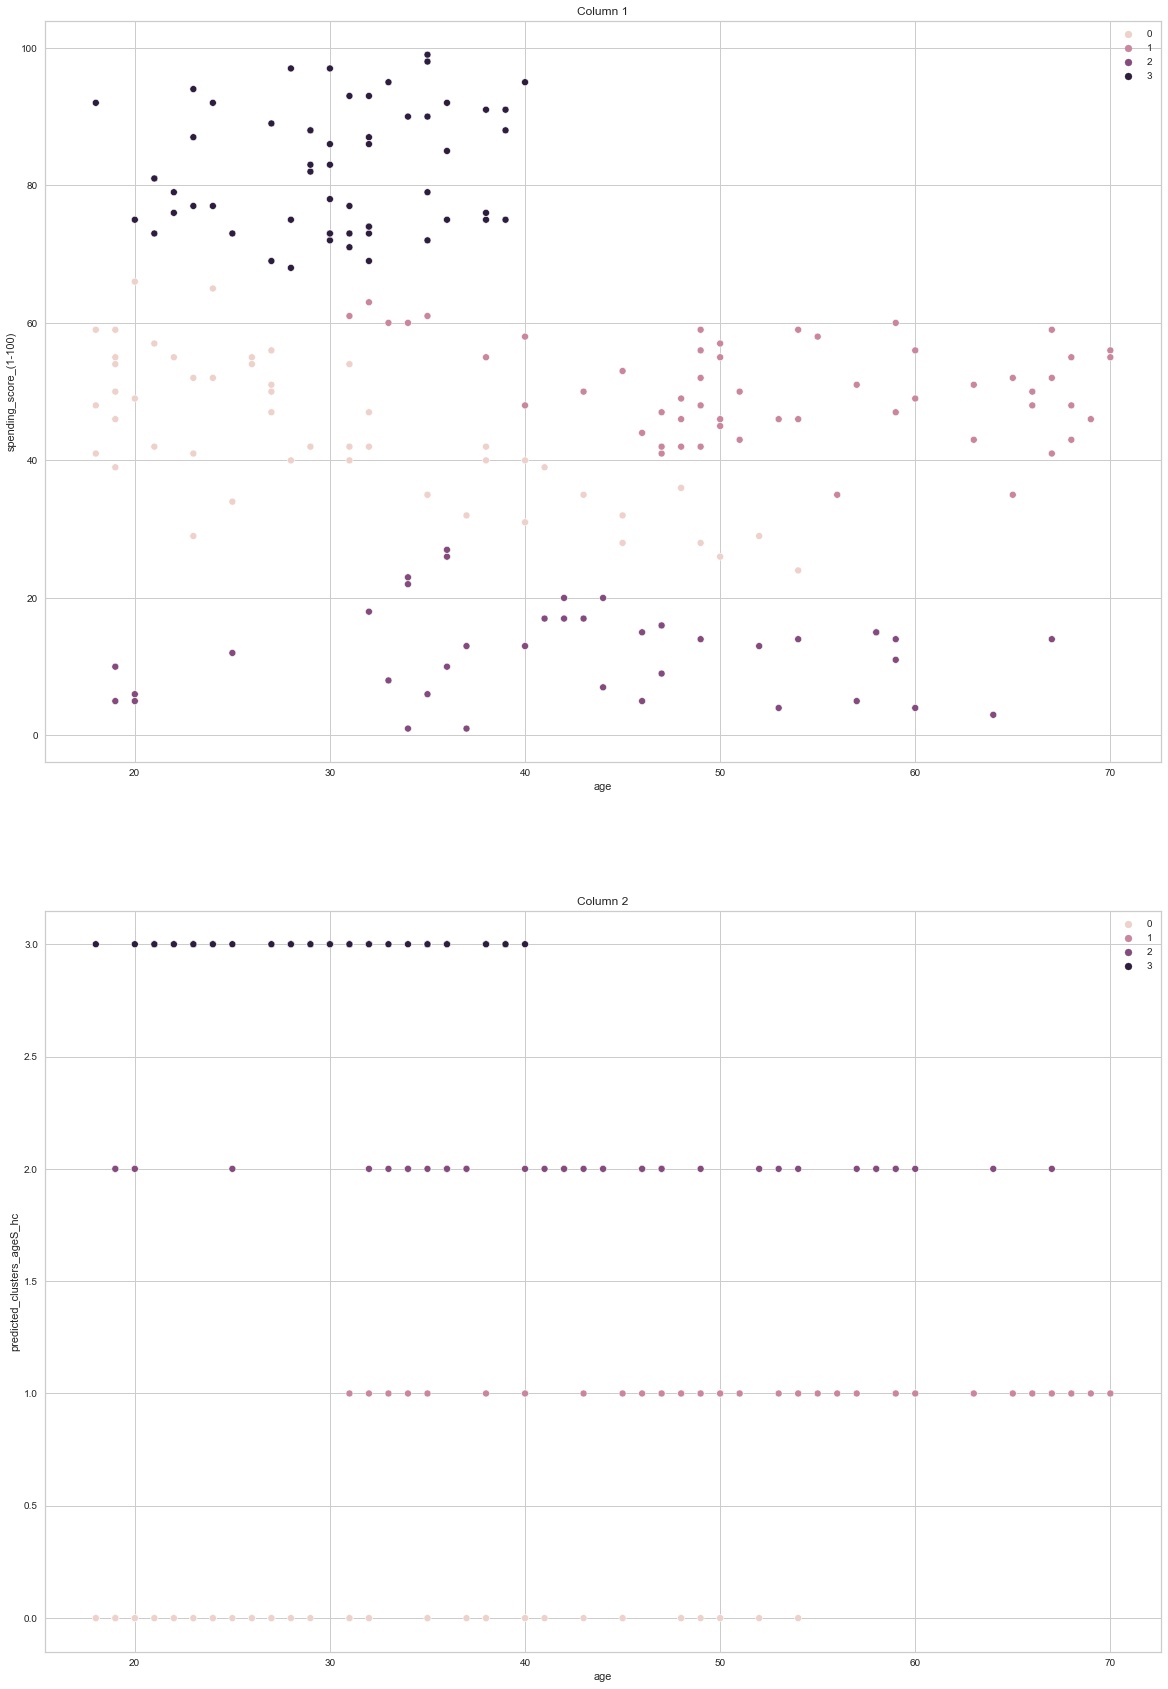

In [241]:
plt.figure(figsize = (20, 30))

for i in range(1, 3):
    plt.subplot(2, 1, i)
    plt.title(f"Column {i}")
    sns.scatterplot(data =df1_, x= df1_.iloc[:, 0], y = df1_.iloc[:, i], hue = model_labels);

In [243]:
plt.figure(figsize = (20, 60))


plt.subplot(2, 1, i)
plt.title(f"Column {i}")
plt.scatter(df1_.iloc[:, 0], df1_.iloc[:, i], c = model_labels, cmap = "viridis");

In [ ]:
df1["predicted_clusters_hc"] = AgglomerativeClustering(n_clusters = 5,
                                                       affinity='euclidean',
                                                       linkage='ward').fit_predict(df1)

In [ ]:
index = 0
plt.figure(figsize=(25, 60))

for feature in df1:
    if feature != "predicted_clusters_hc":
        index += 1
        plt.subplot(9, 3, index)
        sns.boxplot(x='predicted_clusters_hc', y=feature, data=df1)

In [ ]:
# df1.groupby("predicted_clusters_hc")["country"].unique()

In [ ]:
# df2["military_power"] = df2["predicted_clusters_hc"].map({  0 : "less_powerfull",
#                                                             1 : "powerfull",
#                                                             2 : "most_powerfull",
#                                                             3 : "more_powerfull",
#                                                             4 : "weak"})
# df2.head()

#### iii. *Visualizing and Labeling All the Clusters* 

### Conclusion

In [ ]:
# Dummies e sokulmuş kategorical feature ları cluster a sokmayız.
# Kümeleme esnasında datadan çıkarılırlar sonrasında tekrar ilave edilirler.
# Müşteriye en fazla insight sağlayacağını düşündüğümüz featurelearın kendi arasındaki ilişkilerine bakacağız.
# Elmizeki tüm featurelara kümeleme uygulamak yerine bana en fazla hangi feature lar insight sağlar onları bulup onları kümelemeye sokmalıyız.
# 2 insight:
# 1. yaşı artanlar harcamaya yönelmiyorlar, daha az harcıyorlar. (spending score - age arasındaki corr: -.33 yani spending score arttıkça yaş azalıyor)
# 2. Annual_income a bağlı olarak harcama değişmiyor.. (annual_income-spending_score arasındaki corr: 0.0099 neredeyse hiç korele değil)
# box plotta nerelerde yoğunluk olduğunu göremiyorum fakat violinplotta yoğunluğu görebiliyorum. (şişkin kısımlar)
# kümeler neredeyse çok net belli oluyor. ortadaki kümede bayan ağırlığı dikkat çekiyor.
# nümerik verilerde K-means daha iyi çalışıyor.
# datamdaki nümerik verilere baktığımda scalaları birbirine yakın. bu yüzden scaling yapmama gerek yok. Bu durumda deniyorum, scale edilmemiş score um daha yüksek olduğu için scale etmiyorum.
# silüet skorları birbirine yakın olduğunda görsel olarak (scatter vs.) değerlerin dağılımlarına bakıyorum. kümeleme hangisinde daha iyi gözüküyorsa onu seçiyorum.
# bütün kümelemelerin silüet skoru 0 a çok yakın veya negatif ise daha fazla kümeleme yapman gerektiği anlamına gelir.
# Bir de yellowbric.cluster ile baktığımda bazı noktaların negatif score verdiğini gözlemliyoruz. neden?
# kümeleme mantığı nasıl çalışır? kümelerin merkezine uzaklık hangisine daha yakınsa gözlemi ona atar. peki bu durumda kırmızı nokta hangi kümeye ait olacak?
# b--> o kümenin merkezine olan uzaklık. a ise o kümenin diğer gözlemlerine olan uzaklıkların ortalaması. bu durumda formülü uygularsak bazı skorların negatif çıkabileceğini görüyoruz.
# silhouette_score = (b-a)/max(a,b)
# b : the mean nearest-cluster distance
# a : the mean intra-cluster distance
# for red point,
# b = 1
# a = ((1+1)**0.5 + (1+1)**0.5)/2  ==> 1.41
# silhouette_score = (1-1.41)/1.41 ==> -0.29